# Project : 25-26: 4369 -- PROGRAMMING FOR DATA ANALYTICS


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__






# Table of Contents
1. [Introduction](#Introduction)
2. [Data Aquisition and Cleaning - ETL](#data-acquisition-and-cleaning)
3. [Exploratory Data Analysis](#eda)
4. [Part 1 : Micro Generation Validation](#examining-inverter-export-measurement-and-utility-import-measurement)
5. [Part 2 : PV Weather Prediction - Random Forest](#predicting-solar-output-from-weather)


## Introduction ##

This project will examine the data from a residential solar system, and perform interesting analysis.

- Part I  : Validate that exported power into the grid and imported to the grid match.
- Part II : Investigate if the power output can be predicted by looking at the weather.
    - Using Random Forrest

The following data sets will be used:

| Data Source | Description | File Type |
|:---|:---:|---:|
| Solis Inverter | This report contains various power kWh measurements for a day at an hourly grain | xls |
| Solis Inverter | This report contains various power kWh measurements for a month at a daily grain | xls |
| Solis Inverter | This report contains various power kWh measurements for a year at a monthly grain | xls |
| Bord Gáis / ESB | This report contains daily export to grid | csv |
| Meteostat | Dublin Airport Weather | csv / api |
| CAS | Solar Radiation | csv / api |

The loaded data sets will be saved to a sqlite3 database. The database and tables will be used in Part 1.

#### Development Environment

-  __Programing Language__ : Jupyter Notebooks / python 3.11
-  __IDE__                 : VS Code
-  __Git Path__            : [PFDA-programming-for-data-analytics](https://github.com/clydewatts1/PFDA-programming-for-data-analytics)
-  __Copilot/AI__            : github copilt , GEMINI   



__Note__
- The Jupyter Note Book take about 10-15 Minutes to Complete
- My laptop has 32 GB memmory - the jupyter notebook uses about 8 GB. Please don't run if you have 8 GB or less


## Conclusion Summary

__TODO__: Put summary here

__Imports__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets
    import ipywidgets

In [3]:
try:
    import shap
except ImportError:
    !pip install shap
    import shap

In [4]:
# parquet and feather support
try:
    import pyarrow.feather as feather
except ImportError:
    !pip install pyarrow
    import pyarrow.feather as feather
try:
    import pyarrow.parquet as pq
except ImportError:
    !pip install pyarrow
    import pyarrow.parquet as pq
    

In [5]:
from xml.parsers.expat import errors
import scipy.stats as stats
# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


__Globals__

![Residential house roof with two sections of solar panels installed at 30-degree angle. West-South-West roof section (Azimuth 245°) contains 11 panels, East-North-East roof section (Azimuth 65°) contains 7 panels. Surrounding area shows green landscaping and neighboring properties.](images/Picture_Of_Roof.png)


In [6]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


__Helper Functions__

These are function which are used to do useful tasks

- sqlite3_table_schema - dumps the ddl of sql lite table

[sqlite3 table schema](https://sqlite.org/faq.html#:~:text=If%20you%20are%20running%20the,including%20all%20tables%20and%20indices.)

In [7]:
def sqlite3_table_schema(conn, table_name):
    """
    Connects to the SQLite database at db_path and retrieves the schema of the specified table_name.
    Prints the schema in a formatted table.
    """
    csr = conn.cursor()
    csr.execute(f"PRAGMA table_info({table_name})")
    columns = csr.fetchall()

    print(f"--- Schema for '{table_name}' ---")
    print(f"{'ID':<5} {'Name':<15} {'Type':<10} {'NotNull':<10}")
    print("-" * 45)

    for col in columns:
        cid, name, dtype, notnull, dflt_value, pk = col
        print(f"{cid:<5} {name:<15} {dtype:<10} {notnull:<10}")


## Data Acquisition And Cleaning

The data loads will extract from various sources and load will do the following

1. Extract from source and write a raw csv file. The raw data is as is from the source , light touch transformation (/data/raw)
2. The data is transformed into a dataframe
3. The data frame is saved to a csv file (data/processed) _Parquet is a better option_
4. Saved to a sqlite table


__High Level Flow__ 


![Transform](images\TRANSFORM.png)



### Database Setup


![Database](images/TABLES.png)

In [8]:
print("Ensuring database directory exists...")
try:
    os.makedirs(f'{DATA_DIR}/db_sqlite/', exist_ok=True)
    print("Database directory ensured at:", f'{DATA_DIR}/db_sqlite/')
except Exception as e:
    print("Error creating database directory:", e)
print("Connecting to SQLite database...")
con = sqlite3.connect(SQL_DB_FILE)
sys_cur = con.cursor()
print("Connected to SQLite database at:", SQL_DB_FILE)

Ensuring database directory exists...
Database directory ensured at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite/
Connecting to SQLite database...
Connected to SQLite database at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite//big_project_db.sqlite3


### Solis Data Load

The solis data is manually extracted from the solas cloud client interface. This application requires a user logon and password
The following are extracted

- Daily 
- Monthly
- Yearly

[Solis Webpage](https://www.soliscloud.com/)



### Load and Populate Solar Panel Data ###

This analysis utilizes home solar system inverter data, aggregated on daily, monthly, and yearly scales. The data was manually exported from the solar provider's portal as XLS files. Overall data quality is robust; minor gaps exist due to historical power outages but do not hinder the analysis.

The data is placed in the directory ./big_project/data/raw_data/solar. 

The approach to loading loading the 3 file types is very similar.

1. Scan the directory looking for all files matching the pattern using glob
2. Load each XLS file into a seperate dataframe
3. Lightly transform each datafram
4. Merge all the dataframes into one large dataframe
5. Save the dataframe as a csv
6. Save the datagram as a table in database.

[Home Solar System Website](https://www.soliscloud.com/station/stationDetails/generalSituation/1298491919449681542?glyun_vue2=%2F%23%2Fstation) 


[pandas read excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) 


[xlrd](https://pypi.org/project/xlrd/) 




#### Load Weekly Raw Data

__Directory:__  big_project/data/solar   
__File Name:__  Daily*.xls

__Columns__

-  Number (date)
-  Time	
-  Working State	
-  PV(W) : Solar Power Generation
-  Battery(W) : Battery In/Outs	
-  Grid(W)	  : Grid In/Out
-  Load(W)	  : Usage
-  SOC(%)     : Battery Charge Percentage

In [9]:
# Load daily solar data
all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Daily*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%d-%m-%Y').date()
    else:
        print("DQ Issue: Date not found in header")
        break
    # Get Total Yield from header oday Yield(kWh):29.500kWh
    total_yield_label = df_header.iat[3,0]
    result_yield = re.search(r'oday Yield\(kWh\):([\d\.]+)kWh', str(total_yield_label))
    if result_yield:
        total_yield = float(result_yield.group(1))
    # The file needs to be read from line 29
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    all_dfs.append(df)
# Combine all at once
df_raw_daily_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
print("Loaded solar data shape:", df_raw_daily_solar.shape)
# Convert to Time column to datetime.time 12:23:45 format
df_raw_daily_solar['Time'] = pd.to_datetime(df_raw_daily_solar['Time'], format='%H:%M:%S').dt.time
# Combine Date and Time into a single DateTime column
df_raw_daily_solar['DateTime'] = df_raw_daily_solar.apply(lambda row: datetime.datetime.combine(row['Date'], row['Time']), axis=1)
# Reset Index
df_raw_daily_solar.reset_index(drop=True, inplace=True)

# Display first few rows
df_raw_daily_solar.head()


Loaded solar data shape: (118142, 11)


,Date,Number,Time,Working State,PV(W),Battery(W),Grid(W),Load(W),SOC(%),Total_Yield(kWh),Source_File,DateTime
0,2024-09-12,1,00:00:00,Online,1.0,-115.72,6.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:00:00
1,2024-09-12,2,00:05:00,Online,1.0,-210.00,0.0,211.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:05:00
2,2024-09-12,3,00:10:00,Online,1.0,-199.50,1.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:10:00
3,2024-09-12,4,00:15:00,Online,1.0,-199.50,0.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:15:00
4,2024-09-12,5,00:20:00,Online,1.0,-194.25,77.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:20:00


#### Write to CSV and Database

[to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)
[to_sql](https://pandas.pydata.org/pandas-docs/version/2.1.3/reference/api/pandas.DataFrame.to_sql.html)

In [10]:
def write_csv_and_database(df, table_name, conn):
    """
    Writes the DataFrame to a CSV file and a SQLite database table.
    """
    csv_file_path = f'{DATA_DIR}/processed_data/{table_name}.{BACKUP_FILE_TYPE}'
    if BACKUP_FILE_TYPE == 'feather':
        try:
            feather.write_feather(df, csv_file_path)
            print(f"DataFrame written to Feather file at: {csv_file_path}")
        except Exception as e:
            print(f"Error writing DataFrame to Feather file: {e}")
    elif BACKUP_FILE_TYPE == 'parquet':
        try:
            pq.write_table(pa.Table.from_pandas(df), csv_file_path)
            print(f"DataFrame written to Parquet file at: {csv_file_path}")
        except Exception as e:
            print(f"Error writing DataFrame to Parquet file: {e}")
    else:
        try:
            # Write to CSV
            df.to_csv(csv_file_path, index=False)
            print(f"DataFrame written to CSV at: {csv_file_path}")
        except Exception as e:
            print(f"Error writing DataFrame to CSV: {e}")
    try:
        # Write to SQLite database
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"DataFrame written to SQLite table: {table_name}")
        sqlite3_table_schema(conn, table_name)
    except Exception as e:
        print(f"Error writing DataFrame to SQLite database: {e}")

In [11]:
write_csv_and_database(df_raw_daily_solar, 'daily_solar_data', con)


DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/daily_solar_data.feather
DataFrame written to SQLite table: daily_solar_data
--- Schema for 'daily_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     Number          INTEGER    0         
2     Time            TIME       0         
3     Working State   TEXT       0         
4     PV(W)           REAL       0         
5     Battery(W)      REAL       0         
6     Grid(W)         REAL       0         
7     Load(W)         REAL       0         
8     SOC(%)          REAL       0         
9     Total_Yield(kWh) REAL       0         
10    Source_File     TEXT       0         
11    DateTime        TIMESTAMP  0         


__Validate Solar dataframe__


__Columns__
-  Date            DATE        
-  Number          INTEGER         
-  Time            TIME         
-  Working State   TEXT         
-  PV(W)           REAL         
-  Battery(W)      REAL         
-  Grid(W)         REAL         
-  Load(W)         REAL         
-  SOC(%)          REAL         
-  Total_Yield(kWh) REAL         
-  Source_File     TEXT         
-  DateTime        TIMESTAMP      

Check for the following
1. Shape
2. Columns
3. Any dates missing
4. Row count per day

In [12]:
print("Combined DataFrame shape:", df_raw_daily_solar.shape)
print("DataFrame info:")
df_raw_daily_solar.info()
print("Columns:", df_raw_daily_solar.columns.tolist())
df_dates = df_raw_daily_solar['Date'].unique()
print(f"Dates Min: {min(df_dates)}")
print(f"Dates Max: {max(df_dates)}")
print("Total unique dates in data:", len(df_dates))
print("Date Range In Days:", (max(df_dates) - min(df_dates)).days)
# Delete all rows after 2025-10-31
df_raw_daily_solar = df_raw_daily_solar[df_raw_daily_solar['Date'] <= datetime.date(2025, 10, 31)]
# Adjusted shape after filtering dates
print("DataFrame shape after filtering dates:", df_raw_daily_solar.shape)
# find missing dates
# create a complete date range
all_dates = pd.date_range(start=min(df_dates), end=max(df_dates))
# get the difference between all_dates and df_dates
missing_dates = all_dates.difference(df_dates)
print("Missing dates:", missing_dates)


Combined DataFrame shape: (118142, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118142 entries, 0 to 118141
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              118142 non-null  object        
 1   Number            118142 non-null  int64         
 2   Time              118142 non-null  object        
 3   Working State     118142 non-null  object        
 4   PV(W)             118142 non-null  float64       
 5   Battery(W)        118142 non-null  float64       
 6   Grid(W)           118142 non-null  float64       
 7   Load(W)           118142 non-null  float64       
 8   SOC(%)            118142 non-null  float64       
 9   Total_Yield(kWh)  118142 non-null  float64       
 10  Source_File       118142 non-null  object        
 11  DateTime          118142 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memor

## Write to CSV and Database

__Plot the Daily Solar Dataframe__

-  Plot the daily count to determine if there are any missing or duplicated data
-  Plot data for one day - duplicating source data graph

Outliers with MORE than 300 records:
Empty DataFrame
Columns: [Date, Record_Count]
Index: []
Columns ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File', 'DateTime']


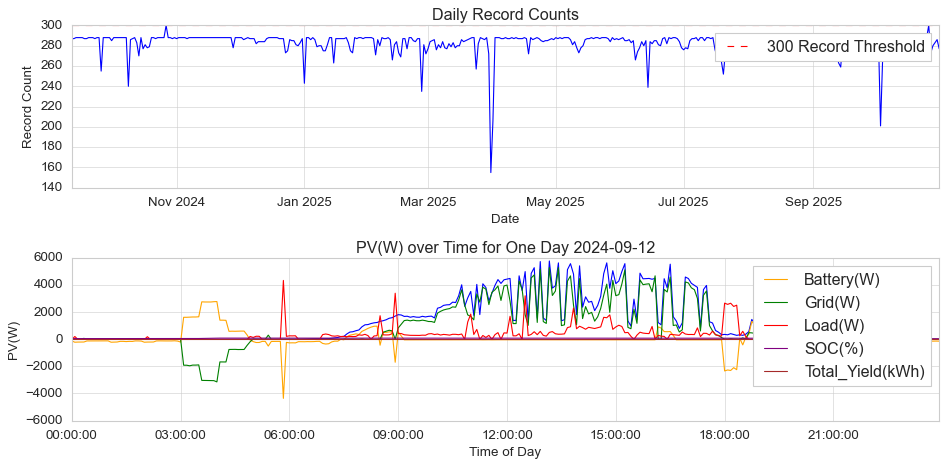

In [13]:
# Do a aggregation to daily level
df_date_counts = df_raw_daily_solar['Date'].value_counts().reset_index()
df_date_counts.columns = ['Date', 'Record_Count']
df_date_counts = df_date_counts.sort_values(by='Date')

# Identify outliers FIRST
outliers = df_date_counts[df_date_counts['Record_Count'] > 300]
print("Outliers with MORE than 300 records:")
print(outliers)

# Now create the duplicates dataframe
df_dups = df_raw_daily_solar[df_raw_daily_solar['Date'].isin(outliers['Date'])][['Date','Source_File']].drop_duplicates().sort_values(by='Date')

fig,ax = plt.subplots(2,1, figsize=(12,6))
# plot count per day , plot a line dotted at 300 , anotate
sns.lineplot(data=df_date_counts, x='Date', y='Record_Count', ax=ax[0])
ax[0].axhline(300, color='red', linestyle='--', label='300 Record Threshold')
ax[0].set_title('Daily Record Counts')
ax[0].set_ylabel('Record Count')
ax[0].legend()
# annotate outliers
for _, row in outliers.iterrows():
    ax[0].annotate(f"{row['Record_Count']}", (row['Date'], row['Record_Count']), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=8)
    # Optionally, you can also use plt.text to add text directly
# Plot 1 day line plot for all features
df_one_day = df_raw_daily_solar[df_raw_daily_solar['Date'] == df_dates[0]].copy()
df_one_day['Time'] = pd.to_datetime(df_one_day['Time'], format='%H:%M:%S')
print("Columns",df_one_day.columns.tolist())
ax[1].set_title(f'PV(W) over Time for One Day {df_dates[0]}')
ax[1].set_ylabel('PV(W)')
ax[1].set_xlabel('Time of Day')
# 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)'
sns.lineplot(data=df_one_day,x='Time',y='PV(W)',ax=ax[1])
sns.lineplot(data=df_one_day,x='Time',y='Battery(W)',ax=ax[1],color='orange',label='Battery(W)')
sns.lineplot(data=df_one_day,x='Time',y='Grid(W)',ax=ax[1],color='green',label='Grid(W)')
sns.lineplot(data=df_one_day,x='Time',y='Load(W)',ax=ax[1],color='red',label='Load(W)')
sns.lineplot(data=df_one_day,x='Time',y='SOC(%)',ax=ax[1],color='purple',label='SOC(%)')
sns.lineplot(data=df_one_day,x='Time',y='Total_Yield(kWh)',ax=ax[1],color='brown',label='Total_Yield(kWh)')
plt.tight_layout()
plt.show()

#### Load Raw Monthly


__Directory:__  big_project/data/solar   
__File Name:__  Monthly*.xls

Each file holds a month data at a daily grain

__Columns__
-  Numbe( Date )
-  Time	
-  Yield(kWh)	
-  Earning(EUR)	
-  Full Load Hours(h)	
-  Charged(kWh)	
-  Discharged(kWh)	
-  Exported(kWh)	
-  Imported(kWh)	
-  Net Import(kWh)	
-  Load(kWh)


In [14]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Monthly*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%m-%Y').date()
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df['Month'] = the_date
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    # Convert date column to date type format is dd-mm-yyyy
    #df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.date
    all_dfs.append(df)
# Combine all at once
df_raw_monthly_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_monthly_solar = df_raw_monthly_solar.rename(columns={'Time':'Date'})
# Convert Date column to date 
df_raw_monthly_solar['Date'] = pd.to_datetime(df_raw_monthly_solar['Date'], format='%d-%m-%Y').dt.date
# Set date as index
#df_raw_monthly_solar.set_index('Date', inplace=True)


##### Write to CSV and Database

In [15]:
write_csv_and_database(df_raw_monthly_solar, 'weekly_solar_data', con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/weekly_solar_data.feather
DataFrame written to SQLite table: weekly_solar_data
--- Schema for 'weekly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Number          INTEGER    0         
1     Date            DATE       0         
2     Yield(kWh)      REAL       0         
3     Earning(EUR)    REAL       0         
4     Full Load Hours(h) REAL       0         
5     Charged(kWh)    REAL       0         
6     Discharged(kWh) REAL       0         
7     Exported(kWh)   REAL       0         
8     Imported(kWh)   REAL       0         
9     Net Import(kWh) REAL       0         
10    Load(kWh)       REAL       0         
11    Month           DATE       0         
12    Source_File     TEXT       0         


__Validate Raw Monthly__


In [16]:

print("Combined Monthly DataFrame shape:", df_raw_monthly_solar.shape)  
print("DataFrame info:")
df_raw_monthly_solar.info()
print("Columns:", df_raw_monthly_solar.columns.tolist())
print("First 5 rows:")

# get min and max Date columns that will indicate range
min_date = df_raw_monthly_solar['Date'].min()
max_date = df_raw_monthly_solar['Date'].max()
no_dates = (max_date - min_date).days + 1
print("No dates in range:", no_dates)
# Date datatype check
print("Date column datatype:", df_raw_monthly_solar['Date'].dtype)
print(f"Date range: {min_date} to {max_date}")
#no_of_days = (max_date - min_date).days + 1
#print(f"Total number of days in range: {no_of_days}")
# Count unique dates
unique_dates = df_raw_monthly_solar['Date'].nunique()
print(f"Unique dates count: {unique_dates}")
if unique_dates == no_dates:
    print("No missing dates in the monthly solar data.")

Combined Monthly DataFrame shape: (434, 13)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              434 non-null    int64  
 1   Date                434 non-null    object 
 2   Yield(kWh)          434 non-null    float64
 3   Earning(EUR)        434 non-null    float64
 4   Full Load Hours(h)  434 non-null    float64
 5   Charged(kWh)        434 non-null    float64
 6   Discharged(kWh)     434 non-null    float64
 7   Exported(kWh)       434 non-null    float64
 8   Imported(kWh)       434 non-null    float64
 9   Net Import(kWh)     434 non-null    float64
 10  Load(kWh)           434 non-null    float64
 11  Month               434 non-null    object 
 12  Source_File         434 non-null    object 
dtypes: float64(9), int64(1), object(3)
memory usage: 44.2+ KB
Columns: ['Number', 'Date', 'Yield(kW

__Plot Monthly Data Frame__

Observe the Yield is dependent on the time of year , that is the season. 

 Date                
 Yield(kWh)                 
 Full Load Hours(h)  
 Charged(kWh)        
 Discharged(kWh)     
 Exported(kWh)       
 Imported(kWh)       
 Net Import(kWh)     
 Load(kWh)           

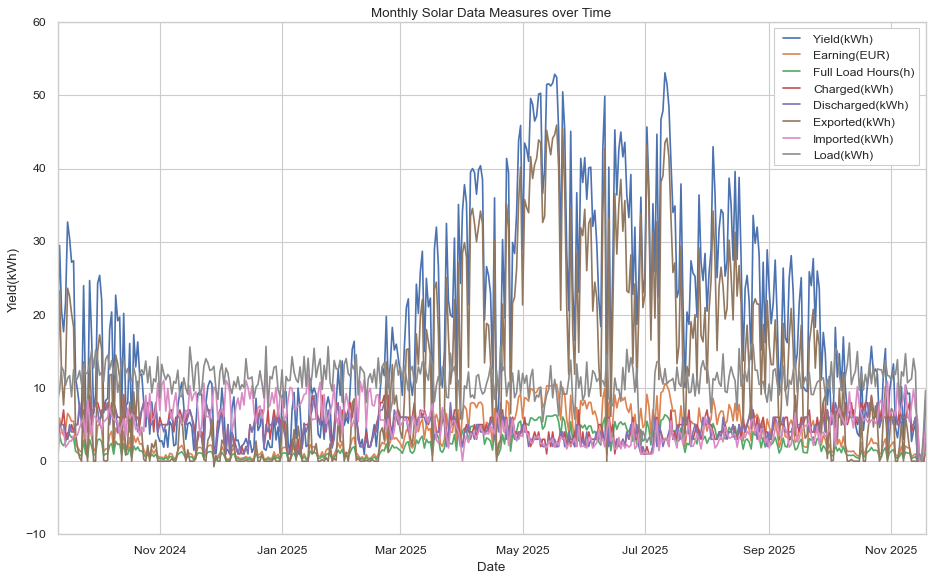

In [17]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Monthly Solar Data Measures over Time')
for column in df_raw_monthly_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_monthly_solar, x='Date', y=column, label=column)
plt.legend()
plt.show()

#### Load Yearly Raw Data


__Directory:__  big_project/data/solar   
__File Name:__  Annual*.xls

Each file holds a yearly data at a monthly grain

__Columns__
-  Number	
-  Time	
-  Yield(kWh)	
-  Earning(EUR)	
-  Full Load Hours(h)	
-  Charged(kWh)	
-  Discharged(kWh)	
-  Exported(kWh)	
-  Imported(kWh)	
-  Net Import(kWh)	
-  Load(kWh)



In [18]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Annual*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_annual_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_annual_solar = df_raw_annual_solar.rename(columns={'Time':'Month'})
# Create Date column from Month
df_raw_annual_solar['Date'] = '01-' + df_raw_annual_solar['Month']
# Convert Date column to datetime
df_raw_annual_solar['Date'] = pd.to_datetime(df_raw_annual_solar['Date'], format='%d-%m-%Y').dt.date

    

__Validate Yearly__

In [19]:
print("Combined Annual DataFrame shape:", df_raw_annual_solar.shape)  
print("DataFrame info:")
df_raw_annual_solar.info()
print("Columns:", df_raw_annual_solar.columns.tolist())
df_raw_annual_solar.head(16)

Combined Annual DataFrame shape: (15, 14)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                15 non-null     object 
 1   Number              15 non-null     int64  
 2   Month               15 non-null     object 
 3   Yield(kWh)          15 non-null     float64
 4   Earning(EUR)        15 non-null     float64
 5   Full Load Hours(h)  15 non-null     float64
 6   Charged(kWh)        15 non-null     float64
 7   Discharged(kWh)     15 non-null     float64
 8   Exported(kWh)       15 non-null     float64
 9   Imported(kWh)       15 non-null     float64
 10  Net Import(kWh)     15 non-null     float64
 11  Load(kWh)           15 non-null     float64
 12  Total_Yield(kWh)    15 non-null     float64
 13  Source_File         15 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 

,Date,Number,Month,Yield(kWh),Earning(EUR),Full Load Hours(h),Charged(kWh),Discharged(kWh),Exported(kWh),Imported(kWh),Net Import(kWh),Load(kWh),Total_Yield(kWh),Source_File
0,2025-01-01,1,01-2025,210.0,42.00,25.12,144.0,133.0,60.48,234.24,173.76,372.76,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
1,2025-02-01,2,02-2025,237.0,47.40,28.35,150.0,140.0,91.56,195.48,103.92,330.92,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
2,2025-03-01,3,03-2025,602.0,120.40,72.01,175.0,161.0,388.20,156.48,-231.72,356.28,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
3,2025-04-01,4,04-2025,896.0,179.20,107.18,139.0,131.0,687.36,116.04,-571.32,316.68,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
4,2025-05-01,5,05-2025,1280.0,256.00,153.11,101.0,92.0,1053.60,86.76,-966.84,304.16,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
5,2025-06-01,6,06-2025,994.5,198.90,118.96,100.0,93.0,755.64,78.60,-677.04,310.46,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
6,2025-07-01,7,07-2025,981.7,196.34,117.43,116.0,112.0,752.52,89.88,-662.64,315.06,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
7,2025-08-01,8,08-2025,878.0,175.60,105.02,144.0,132.0,624.60,113.40,-511.20,354.80,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
8,2025-09-01,9,09-2025,571.5,114.30,68.36,157.0,150.0,355.08,112.92,-242.16,322.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
9,2025-10-01,10,10-2025,292.1,58.42,34.94,203.0,192.0,107.52,197.76,90.24,371.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls


__Plot Data__

Plot to see what it looks like. Should see a bell like curve because of the seasonality



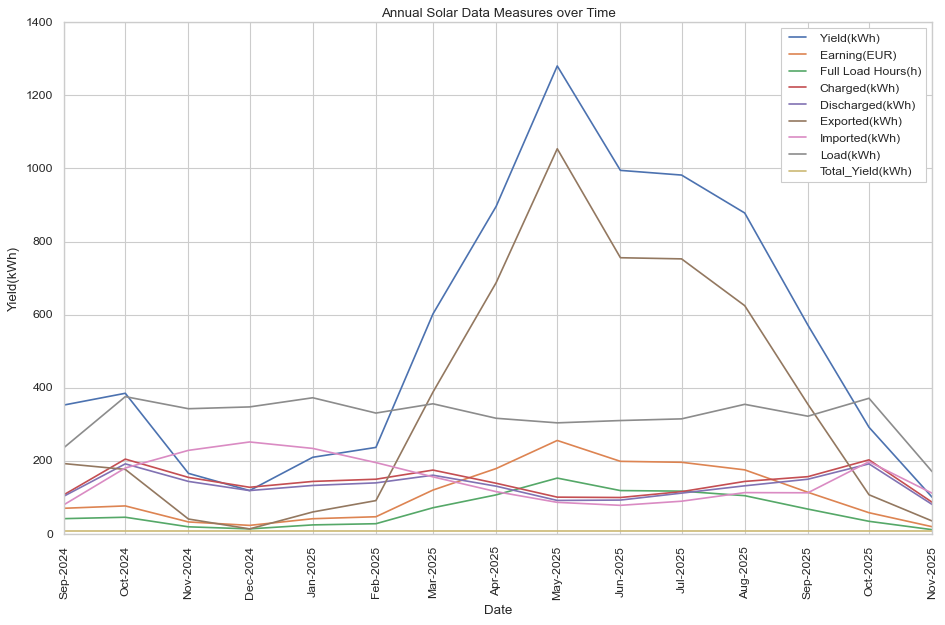

In [20]:
# plot date vs all the other measures in kWh on one plot
import matplotlib.dates as mdates
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Annual Solar Data Measures over Time')
for column in df_raw_annual_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_annual_solar, x='Date', y=column, label=column)
ax = plt.gca() # Get current axis

# 1. Set the Locator: Tell matplotlib to put a tick at every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 2. Set the Formatter: Tell matplotlib how to write the text (e.g., Jan-2023)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# 3. Rotate ticks
plt.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()

In [21]:
##### Write to CSV and Database

In [22]:
write_csv_and_database(df_raw_annual_solar, 'monthly_solar_data', con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/monthly_solar_data.feather
DataFrame written to SQLite table: monthly_solar_data
--- Schema for 'monthly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     Number          INTEGER    0         
2     Month           TEXT       0         
3     Yield(kWh)      REAL       0         
4     Earning(EUR)    REAL       0         
5     Full Load Hours(h) REAL       0         
6     Charged(kWh)    REAL       0         
7     Discharged(kWh) REAL       0         
8     Exported(kWh)   REAL       0         
9     Imported(kWh)   REAL       0         
10    Net Import(kWh) REAL       0         
11    Load(kWh)       REAL       0         
12    Total_Yield(kWh) REAL       0         
13    Source_File     TEXT       0         


In [23]:
# List all tables in the database
sys_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = sys_cur.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
esb_microgen_data
daily_solar_date
daily_esb_microgen_data
hourly_weather_data
hourly_solar_copernicus_data
hourly_solar_copernicus_enriched_data
daily_solar_data
weekly_solar_data
monthly_solar_data


### Load ESB Microgeneration Data

In [24]:
# load into pandas dataframe csv file
df_raw_esb_microgen = pd.read_csv(f'{RAW_DATA_DIR}/esb/BGE_Export_HDF_18_11_2025.csv')
# change Date column to date
df_raw_esb_microgen['Date'] = pd.to_datetime(df_raw_esb_microgen['Date']).dt.date 
# change Date to index
#df_raw_esb_microgen.set_index('Date', inplace=True)

In [25]:
print("ESB Microgen DataFrame shape:", df_raw_esb_microgen.shape)
print("DataFrame info:")
df_raw_esb_microgen.info()
print("Columns:", df_raw_esb_microgen.columns.tolist())
print("First 5 rows:")
print(df_raw_esb_microgen.head())


ESB Microgen DataFrame shape: (435, 4)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPRN                 435 non-null    int64  
 1   Date                 435 non-null    object 
 2   Export Volume (kWh)  435 non-null    float64
 3   Export Type          435 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 13.7+ KB
Columns: ['MPRN', 'Date', 'Export Volume (kWh)', 'Export Type']
First 5 rows:
         MPRN        Date  Export Volume (kWh) Export Type
0  9999999999  2024-09-05                  0.0     Metered
1  9999999999  2024-09-06                  0.0     Metered
2  9999999999  2024-09-07                  0.0     Metered
3  9999999999  2024-09-08                  0.0     Metered
4  9999999999  2024-09-09                  0.0     Metered


#### Write to CSV and Database

In [26]:

write_csv_and_database(df_raw_esb_microgen, 'daily_esb_microgen_data', con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/daily_esb_microgen_data.feather
DataFrame written to SQLite table: daily_esb_microgen_data
--- Schema for 'daily_esb_microgen_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     MPRN            INTEGER    0         
1     Date            DATE       0         
2     Export Volume (kWh) REAL       0         
3     Export Type     TEXT       0         


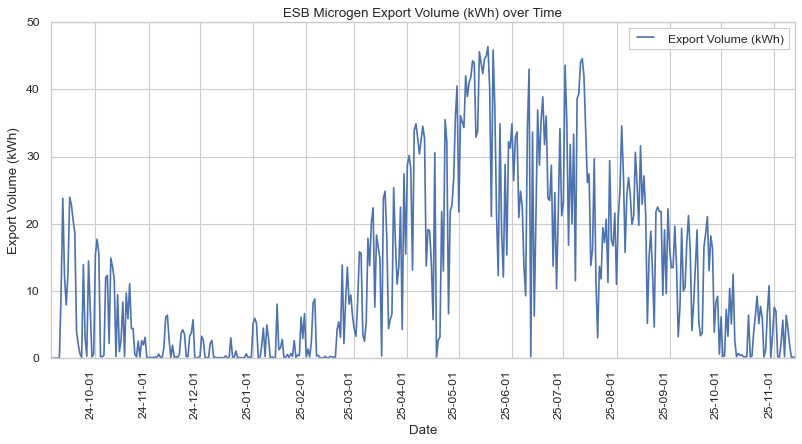

In [27]:

# Plot esb microgen data
ss = df_raw_esb_microgen[['Date','Export Volume (kWh)']]
ss.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=ss, ax=ax)
plt.title('ESB Microgen Export Volume (kWh) over Time')
plt.xlabel('Date')
plt.ylabel('Export Volume (kWh)')
# set x axis major ticks to monthly at 90 degrees
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%y-%m-%d'))
plt.gcf().autofmt_xdate(rotation=90)
plt.grid(True)
plt.show()


### Load  Weather Data

The first iteration the local weather was downloaded from Data.gov.ie - Dublin Airport Hourly Data. After some investigation , a more general source was found Meteostat. This uses a library with a api to download the weather for a given longtitude and latitude. The results are cached . The advantage of meteostat source is that it is consistent.

[Meteostat](https://meteostat.net/en/)  
[Meteostat Columns](https://dev.meteostat.net/formats.html#time-format)  
[Dublin Airport Hourly Data](https://data.gov.ie/dataset/dublin-airport-hourly-data)  
[Dublin Airport Weather](https://cli.fusio.net/cli/climate_data/webdata/hly532.csv)  



In [28]:
# Load hourly weather data for Dublin
#df_weather_dublin = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/hly532.csv', skiprows=23)
mt.Stations.cache_dir = METEOSTAT_CACHE_DIR
stations = mt.Stations()
# Get the stations near the specified latitude and longitude
stations = stations.nearby(LATITUDE, LONGITUDE)
# Get the first station from the list , which is usually the closest one
df_station = stations.fetch(1)
# Reset index to access station ID
df_station.reset_index(inplace=True)
print(f"Station ID: {df_station['id'][0]}")
print(f"Station Name: {df_station['name'][0]}")
print(f"Station Distance: {df_station['distance'][0]:.2f} m")
# Get local station ID
station_id = df_station['id'][0]
# Get hourly data
data = mt.Hourly(station_id, WEATHER_START_DATE, WEATHER_END_DATE,timezone='Europe/Dublin')
# fetch the data
weather_df = data.fetch()
# set index to default integer index
weather_df.reset_index(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# fix missing values by forward filling and then backward filling
weather_df.ffill(inplace=True)
weather_df.bfill(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# explode the dataframe time to 10 minute intervals
weather_df.set_index('time', inplace=True)
# No longer needed to resample - it is already hourly
#weather_df = weather_df.resample('10min').interpolate(method='linear')
weather_df.reset_index(inplace=True)
# Print exploratory information
print("Exploratory Data Analysis of Weather DataFrame")
print("Columns before selection:", weather_df.columns.tolist())
# we are only interested in time, temperature, humidity, and solar radiation
weather_df = weather_df[['time', 'temp', 'rhum', 'tsun','coco','prcp','dwpt','wdir','wspd','wpgt','pres','snow']]
# rename columns for clarity
weather_df.rename(columns={'time': 'DateTime', 'temp': 'Temperature(C)', 'rhum': 'Humidity(%)', 'tsun': 'Sunshine Duration','coco': 'Condition Code','tavg': 'Average Temperature(C)','tmin': 'Minimum Temperature(C)','prcp': 'Precipitation(mm)','dwpt': 'Dew Point(C)','wdir': 'Wind Direction(deg)','wspd': 'Wind Speed(m/s)','wpgt': 'Wind Gust(m/s)','pres': 'Pressure(hPa)','snow': 'Snow Depth(cm)'}, inplace=True)
# Change DateTime - Drop timezone info to Europe/Dublin need that later for merging with other data
weather_df['DateTime'] = weather_df['DateTime'].dt.tz_convert('Europe/Dublin').dt.tz_localize(None)
print("Weather DataFrame shape:", weather_df.shape)
print("DataFrame info:")
weather_df.info()
print("Columns:", weather_df.columns.tolist())
print("First 5 rows:")
print(weather_df.head())
# Breakdown of Condition Code values
condition_code_counts = weather_df['Condition Code'].value_counts().sort_index()
print("Condition Code Breakdown:")
print(condition_code_counts)


Station ID: 03969
Station Name: Dublin Airport
Station Distance: 29619.04 m
Missing values in each column:
prcp      483
snow    16708
Missing values in each column:
Series([], )
Exploratory Data Analysis of Weather DataFrame
Columns before selection: ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
Weather DataFrame shape: (17414, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             17414 non-null  datetime64[ns]
 1   Temperature(C)       17414 non-null  Float64       
 2   Humidity(%)          17414 non-null  Float64       
 3   Sunshine Duration    17414 non-null  Float64       
 4   Condition Code       17414 non-null  Float64       
 5   Precipitation(mm)    17414 non-null  Float64       
 6   Dew Point(C)         17414 n

__One Hot Encoding Of Condition Code__

Codition Code is a weather condition code it does go from 0 - clear , 24 - storm , it is a catagorical in order of serverity of weather . The condition code is ordinal variable . The initial training approach was to use the condition code as a continous variable which may lead to some "fake ( gemini) " maths , that is rain < snow , from a forcasting point of view , the solar output related to the code is important , and not what is happening if snow , and rain result in the same result of sun availability then although they are greater numerical in the condition code . They do mean the same thing. 

The technique to resolve this is one hot encoding , that is each code becomes a feature . To do investigation there will be hierarchy one hot encoding , although not idea , it will give flexibily in experienentation of training options . The disadvantage of one hot encoding is that it leads to explosion of features , instead of 1 feature , there is now 26 catagories - the 24 existing ones , Nan , and hight than 24 . 


__One Hot Encoding Of Condition Code__
| Code | Weather Condition | One Hot | Level 2 One Hot |
|:---:|:---|:---:|:---:|
| 1 | Clear | clear | good_visibility |
| 2 | Fair | fair | good_visibility |
| 3 | Cloudy | cloudy | moderate_visibility |
| 4 | Overcast | overcast | moderate_visibility |
| 5 | Fog | fog | poor_visibility |
| 6 | Freezing Fog | freezing_fog | poor_visibility |
| 7 | Light Rain | light_rain | precipitation |
| 8 | Rain | rain | precipitation |
| 9 | Heavy Rain | heavy_rain | precipitation |
| 10 | Freezing Rain | freezing_rain | precipitation |
| 11 | Heavy Freezing Rain | heavy_freezing_rain | precipitation |
| 12 | Sleet | sleet | precipitation |
| 13 | Heavy Sleet | heavy_sleet | precipitation |
| 14 | Light Snowfall | light_snowfall | snow |
| 15 | Snowfall | snowfall | snow |
| 16 | Heavy Snowfall | heavy_snowfall | snow |
| 17 | Rain Shower | rain_shower | precipitation |
| 18 | Heavy Rain Shower | heavy_rain_shower | precipitation |
| 19 | Sleet Shower | sleet_shower | precipitation |
| 20 | Heavy Sleet Shower | heavy_sleet_shower | precipitation |
| 21 | Snow Shower | snow_shower | snow |
| 22 | Heavy Snow Shower | heavy_snow_shower | snow |
| 23 | Lightning | lightning | severe_weather |
| 24 | Hail | hail | severe_weather |
| 25 | Thunderstorm | thunderstorm | severe_weather |
| 26 | Heavy Thunderstorm | heavy_thunderstorm | severe_weather |
| 27 | Storm | storm | severe_weather |


In [29]:
# append to weather_df the one hot encoding coditon as specified in the 

In [30]:
# ...existing code...
# append to weather_df the one hot encoding coditon as specified in the 
code_to_level1 = {
    1: "clear", 2: "fair",
    3: "cloudy", 4: "overcast",
    5: "fog", 6: "freezing_fog",
    7: "light_rain", 8: "rain", 9: "heavy_rain",
    10: "freezing_rain", 11: "heavy_freezing_rain",
    12: "sleet", 13: "heavy_sleet",
    14: "light_snowfall", 15: "snowfall", 16: "heavy_snowfall",
    17: "rain_shower", 18: "heavy_rain_shower",
    19: "sleet_shower", 20: "heavy_sleet_shower",
    21: "snow_shower", 22: "heavy_snow_shower",
    23: "lightning", 24: "hail",
    25: "thunderstorm", 26: "heavy_thunderstorm",
    27: "storm",
}
code_to_level2 = {
    1: "good_visibility", 2: "good_visibility",
    3: "moderate_visibility", 4: "moderate_visibility",
    5: "poor_visibility", 6: "poor_visibility",
    7: "precipitation", 8: "precipitation", 9: "precipitation",
    10: "precipitation", 11: "precipitation",
    12: "precipitation", 13: "precipitation",
    14: "snow", 15: "snow", 16: "snow",
    17: "precipitation", 18: "precipitation",
    19: "precipitation", 20: "precipitation",
    21: "snow", 22: "snow",
    23: "severe_weather", 24: "severe_weather",
    25: "severe_weather", 26: "severe_weather",
    27: "severe_weather",
}

# Map codes to labels (fallback to 'other' for unexpected codes/NAs)
weather_df["level1_label"] = weather_df["Condition Code"].map(code_to_level1).fillna("other")
weather_df["level2_label"] = weather_df["Condition Code"].map(code_to_level2).fillna("other")

# One-hot encode each level with requested prefixes
level1_ohe = pd.get_dummies(weather_df["level1_label"], prefix="level1",dtype=int)
level2_ohe = pd.get_dummies(weather_df["level2_label"], prefix="level2",dtype=int)

# Attach to the dataframe
weather_df = pd.concat([weather_df, level1_ohe, level2_ohe], axis=1)

# Drop helper label columns (keep original Condition Code)
weather_df.drop(columns=["level1_label", "level2_label"], inplace=True)
# ...existing code...
print(weather_df.columns.tolist())

['DateTime', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


#### Write to CSV and Database

In [31]:
write_csv_and_database(weather_df, 'hourly_weather_data', con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/hourly_weather_data.feather
DataFrame written to SQLite table: hourly_weather_data
--- Schema for 'hourly_weather_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     DateTime        TIMESTAMP  0         
1     Temperature(C)  REAL       0         
2     Humidity(%)     REAL       0         
3     Sunshine Duration REAL       0         
4     Condition Code  REAL       0         
5     Precipitation(mm) REAL       0         
6     Dew Point(C)    REAL       0         
7     Wind Direction(deg) REAL       0         
8     Wind Speed(m/s) REAL       0         
9     Wind Gust(m/s)  REAL       0         
10    Pressure(hPa)   REAL       0         
11    Snow Depth(cm)  REAL       0         
12    level1_clear    INTEGER    0         
13    level1_cloudy   INTEGER    0         


#### Validate Data

Plot the temperature , humidity and solar radiation over time. There are 10K rows , thus it takes some time.
Notice how irish weather is inconsistent. This makes trying to find predict solar output from weather a challenge.



Plot Weather DataFrame shape: (168, 32)


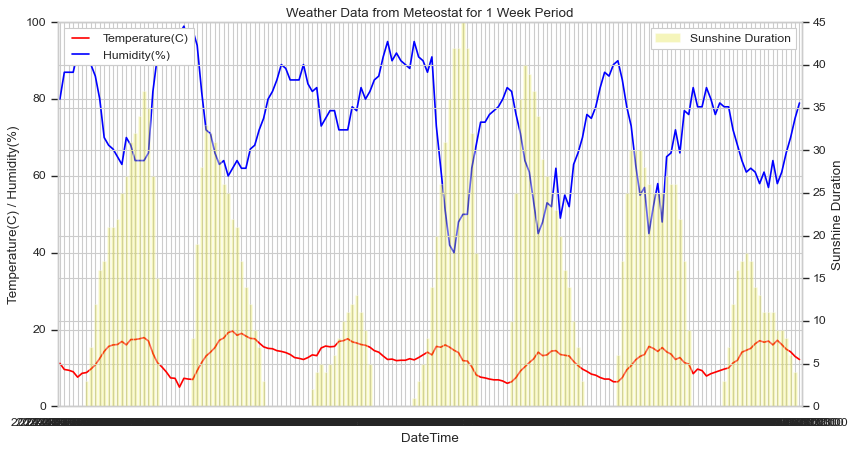

In [32]:
weather_df
# plot the weather data for 1 week period
start_plot_date = datetime.datetime(2024, 6, 1)
end_plot_date = start_plot_date + datetime.timedelta(days=7)
df_plot_weather = weather_df[(weather_df['DateTime'] >= start_plot_date) & (weather_df['DateTime'] < end_plot_date)].copy()
df_plot_weather.reset_index(drop=True, inplace=True)
# convert DateTime to string for better x axis labels
df_plot_weather['DateTime'] = df_plot_weather['DateTime'].dt.strftime('%Y-%m-%d %H:%M')
print("Plot Weather DataFrame shape:", df_plot_weather.shape)
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
sns.lineplot(data=df_plot_weather, x='DateTime', y='Temperature(C)', ax=ax1, color='red', label='Temperature(C)')
sns.lineplot(data=df_plot_weather, x='DateTime', y='Humidity(%)', ax=ax1, color='blue', label='Humidity(%)')
# bar plot for solar radiation - change the color of the bars as they get higher make them more yellow
sns.barplot(data=df_plot_weather, x='DateTime', y='Sunshine Duration', ax=ax2, color='yellow', label='Sunshine Duration', alpha=0.3)
plt.xticks(rotation=90)
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Temperature(C) / Humidity(%)')
ax2.set_ylabel('Sunshine Duration')
plt.title('Weather Data from Meteostat for 1 Week Period')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### Load Copernicus - Atmosphere Data Store

This is one of the best sources of solar radiation at a ground level. It is based on saterlite data from copernicus . I also looks at Nasa and other sources , this looked like the best , and most up to date. The data could either be extracted from the site via a request or via a python API. The API requird a key which would make the project uncessarly complicated. A file was used with a granulary of of 1 minute which was initially 70 MB big , and is reduced to 10 minute granularity before being saved. 
The measure to do the analysis at later stages will be GHI - Global Horizonal All Sky Irradiation ( Gemini ). This is the sum of direct and indirect radiation . It does not take into account the angle and direction of the solar panels . This will be a challenge because it is a split system pointing W and E. 

__Columns__
-  \# Observation period
-  TOA
-  Clear sky GHI
-  Clear sky BHI
-  Clear sky DHI
-  Clear sky BNI
-  GHI
-  BHI
-  DHI
-  BNI
-  Reliability

About 653K rows - sumaries down to 10 minute intervals


(Copernicus - Atmosphere Data Store)[https://ads.atmosphere.copernicus.eu/requests?tab=all]


(CAMS - Solar Radiation Timeseries)[https://ads.atmosphere.copernicus.eu/datasets/cams-solar-radiation-timeseries?tab=overview]



In [33]:

copernicus_project_file_name=f"{RAW_DATA_DIR}/copernicus/Copernicus_Solar_Data_Bettystown_2024_2025.csv"
# replace // with /
print(f"Loading Copernicus solar data from project raw data folder: {copernicus_project_file_name}")
copernicus_project_file_name = copernicus_project_file_name.replace("//","/")
# Load in header
df_copernicus_solar_header = pd.read_csv(copernicus_project_file_name, nrows=42, header=None,delimiter=';')
display(df_copernicus_solar_header)
# Now load from project folder - normal status
print("Loading Copernicus solar data from project raw data folder...")
df_copernicus_solar = pd.read_csv(copernicus_project_file_name, skiprows=42,delimiter=';')
df_copernicus_solar[['From_datetime','To_datetime']] = df_copernicus_solar['# Observation period'].str.split('/', expand=True)
# Convert From_datetime to datetime format this is UTC time
df_copernicus_solar['From_datetime'] = pd.to_datetime(df_copernicus_solar['From_datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
# convert timezone from UTC to Europe/Dublin
df_copernicus_solar['From_datetime'] = df_copernicus_solar['From_datetime'].dt.tz_localize('UTC').dt.tz_convert('Europe/Dublin').dt.tz_localize(None)
# Convert To_datetime to datetime format
# Drop to_datetime column
df_copernicus_solar.drop(columns=['To_datetime'], inplace=True)
# Rename From_datetime to DateTime
df_copernicus_solar.rename(columns={'From_datetime': 'DateTime'}, inplace=True)
# Set to DateTime to index
#df_copernicus_solar.set_index('DateTime', inplace=True)
 # Convert Time into time only
df_copernicus_solar['Time'] = df_copernicus_solar['DateTime'].dt.time
# Convert Date into date only
df_copernicus_solar['Date'] = df_copernicus_solar['DateTime'].dt.date
# Convert Time into time only
df_copernicus_solar['Time'] = pd.to_datetime(df_copernicus_solar['Time'], format='%H:%M:%S').dt.time
# Convert Date into date only
df_copernicus_solar['Date'] = pd.to_datetime(df_copernicus_solar['Date'], format='%Y-%m-%d').dt.date

print("Copernicus Solar DataFrame shape:", df_copernicus_solar.shape)
print("DataFrame info:")
#df_copernicus_solar.info()
print("Columns:", df_copernicus_solar.columns.tolist())
# Convert DateTime to datetime format
print("First 5 rows:")
print(df_copernicus_solar.head())
df_copernicus_solar['DateTime'] = pd.to_datetime(df_copernicus_solar['DateTime'], format='%Y-%m-%d %H:%M:%S')
#df_copernicus_solar

Loading Copernicus solar data from project raw data folder: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//raw_data//copernicus/Copernicus_Solar_Data_Bettystown_2024_2025.csv


,0
0,"# Coding: utf-8,"
1,"# File format version: 2,"
2,# Title: CAMS Radiation Service v4.6 all-sky i...
3,# Content: A time-series of solar radiation r...
4,"# Returns the global,beam and diffus..."
5,# for a selected location (geostatio...
6,# The research leading to these results has re...
7,# Provider: VAISALA with MINES ParisTech (Fran...
8,# More information at: http://www.soda-pro.com...
9,"# Date begin (ISO 8601): 2024-08-22T00:00:00.0,"


Loading Copernicus solar data from project raw data folder...
Copernicus Solar DataFrame shape: (11712, 14)
DataFrame info:
Columns: ['# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'DateTime', 'Time', 'Date']
First 5 rows:
                          # Observation period  TOA  Clear sky GHI  \
0  2024-08-22T00:00:00.0/2024-08-22T01:00:00.0  0.0            0.0   
1  2024-08-22T01:00:00.0/2024-08-22T02:00:00.0  0.0            0.0   
2  2024-08-22T02:00:00.0/2024-08-22T03:00:00.0  0.0            0.0   
3  2024-08-22T03:00:00.0/2024-08-22T04:00:00.0  0.0            0.0   
4  2024-08-22T04:00:00.0/2024-08-22T05:00:00.0  0.0            0.0   

   Clear sky BHI  Clear sky DHI  Clear sky BNI  GHI  BHI  DHI  BNI  \
0            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
1            0.0            0.0            0.0  0.0  0.0  0.0  0.0   
2            0.0            0.0            0.0  0.

#### Write to CSV and Database

In [34]:
write_csv_and_database(df_copernicus_solar,'hourly_solar_copernicus_data',con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/hourly_solar_copernicus_data.feather
DataFrame written to SQLite table: hourly_solar_copernicus_data
--- Schema for 'hourly_solar_copernicus_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     # Observation period TEXT       0         
1     TOA             REAL       0         
2     Clear sky GHI   REAL       0         
3     Clear sky BHI   REAL       0         
4     Clear sky DHI   REAL       0         
5     Clear sky BNI   REAL       0         
6     GHI             REAL       0         
7     BHI             REAL       0         
8     DHI             REAL       0         
9     BNI             REAL       0         
10    Reliability,    TEXT       0         
11    DateTime        TIMESTAMP  0         
12    Time            TIME       0         
13    Date          

#### Validate Data

This is plotting data 

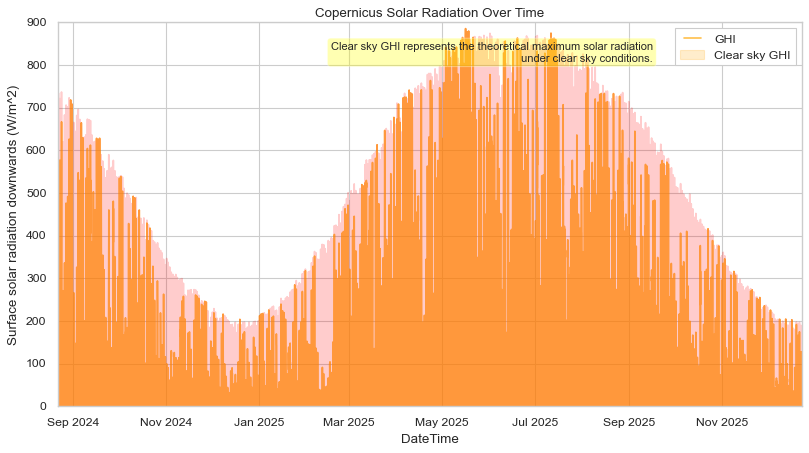

In [35]:
# Plot the Copernicus solar data
plt.figure(figsize=(12,6))
sns.lineplot(data=df_copernicus_solar, x='DateTime', y='GHI', color='orange', alpha=0.7)
sns.lineplot(data=df_copernicus_solar, x='DateTime', y='Clear sky GHI', color='red', alpha=0.2)
plt.title('Copernicus Solar Radiation Over Time')
# Annotate explanation for Clear sky GHI
plt.annotate("Clear sky GHI represents the theoretical maximum solar radiation\nunder clear sky conditions.", xy=(0.80, 0.95), 
             xycoords='axes fraction', fontsize=10, ha='right', va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
#plt.text(0,0,"The Clear sky GHI is the theoretical maximum solar radiation under clear sky conditions.", fontsize=10, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')  
plt.legend(labels=['GHI','Clear sky GHI'])
plt.xlabel('DateTime')
plt.ylabel('Surface solar radiation downwards (W/m^2)')
plt.show()

### Load / Enrich Copericus Data

To calculate solar system performance, we use the pvlib library. This library accounts for critical variables including solar radiation, the location's longitude and latitude, and the specific orientation of the solar array (defined by the roof's azimuth and tilt angle). Because the sun's path varies throughout the year, the angle at which light hits the vertical and horizontal planes of the panels constantly changes, directly impacting energy generation efficiency.

There are two sets of measurements

-  Clear Sky 
    - This the solar radiation without cloud - never happens
-  Standard
    - This is with cloud cover.


[PVLIB Documentation](https://pvlib-python.readthedocs.io/en/stable/)    
[Gemini Prompt](https://gemini.google.com/share/54cd534a5aeb)

In [36]:
import pvlib
df_copernicus_solar_enriched = df_copernicus_solar.copy()

# Set up location
print("Setting up PVLib location...")
location = pvlib.location.Location(latitude=LATITUDE, longitude=LONGITUDE, tz='Europe/Dublin')
print("Location set for PVLib:", location)

# Set DateTime as index for PVLib calculations
df_copernicus_solar_enriched.set_index('DateTime', inplace=True)

# Get solar position
print("Calculating solar position using PVLib...")
solar_position = location.get_solarposition(times=df_copernicus_solar_enriched.index)

# PANE I configuration
print("Calculating solar position and POA irradiance using PVLib...")
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_I_ANGLE,
    surface_azimuth=ROOF_PANE_I_AZIMUTH,
    dni=df_copernicus_solar_enriched['BNI'],
    ghi=df_copernicus_solar_enriched['GHI'],
    dhi=df_copernicus_solar_enriched['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POA_Pane_I(W/m^2)'] = poa['poa_global']

# PANE II configuration
poa_ii = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_II_ANGLE,
    surface_azimuth=ROOF_PANE_II_AZIMUTH,
    dni=df_copernicus_solar_enriched['BNI'],
    ghi=df_copernicus_solar_enriched['GHI'],
    dhi=df_copernicus_solar_enriched['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POA_Pane_II(W/m^2)'] = poa_ii['poa_global']


# PANE I configuration - Clear Sky Model
print("Calculating solar position and POA irradiance using PVLib...")
poac = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_I_ANGLE,
    surface_azimuth=ROOF_PANE_I_AZIMUTH,
    dni=df_copernicus_solar_enriched['Clear sky BNI'],
    ghi=df_copernicus_solar_enriched['Clear sky GHI'],
    dhi=df_copernicus_solar_enriched['Clear sky DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POAC_Pane_I(W/m^2)'] = poac['poa_global']

# PANE II configuration - Clear Sky Model
poa_ii = pvlib.irradiance.get_total_irradiance(
    surface_tilt=ROOF_PANE_II_ANGLE,
    surface_azimuth=ROOF_PANE_II_AZIMUTH,
    dni=df_copernicus_solar_enriched['Clear sky BNI'],
    ghi=df_copernicus_solar_enriched['Clear sky GHI'],
    dhi=df_copernicus_solar_enriched['Clear sky DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

# Add POA to dataframe
df_copernicus_solar_enriched['POAC_Pane_II(W/m^2)'] = poa_ii['poa_global']


# Calculate power output for each pane
df_copernicus_solar_enriched['Power_Pane_I(W)'] = (df_copernicus_solar_enriched['POA_Pane_I(W/m^2)'] * TOTAL_SOLAR_PANE_I_CAPACITY_W * 6) / 1000.0
df_copernicus_solar_enriched['Power_Pane_II(W)'] = (df_copernicus_solar_enriched['POA_Pane_II(W/m^2)'] * TOTAL_SOLAR_PANE_II_CAPACITY_W * 6) / 1000.0
df_copernicus_solar_enriched['Power_ClearSky_Pane_I(W)'] = (df_copernicus_solar_enriched['POAC_Pane_I(W/m^2)'] * TOTAL_SOLAR_PANE_I_CAPACITY_W * 6) / 1000.0
df_copernicus_solar_enriched['Power_ClearSky_Pane_II(W)'] = (df_copernicus_solar_enriched['POAC_Pane_II(W/m^2)'] * TOTAL_SOLAR_PANE_II_CAPACITY_W * 6) / 1000.0
# Clip negative power values to zero
df_copernicus_solar_enriched['Power_Pane_I(W)'] = df_copernicus_solar_enriched['Power_Pane_I(W)'].clip(lower=0)
df_copernicus_solar_enriched['Power_Pane_II(W)'] = df_copernicus_solar_enriched['Power_Pane_II(W)'].clip(lower=0)
df_copernicus_solar_enriched['Power_ClearSky_Pane_I(W)'] = df_copernicus_solar_enriched['Power_ClearSky_Pane_I(W)'].clip(lower=0)
df_copernicus_solar_enriched['Power_ClearSky_Pane_II(W)'] = df_copernicus_solar_enriched['Power_ClearSky_Pane_II(W)'].clip(lower=0)

# Total Power Output
df_copernicus_solar_enriched['Total_Power_Output(W)'] = df_copernicus_solar_enriched['Power_Pane_I(W)'] + df_copernicus_solar_enriched['Power_Pane_II(W)']
df_copernicus_solar_enriched['Total_Power_ClearSky_Output(W)'] = df_copernicus_solar_enriched['Power_ClearSky_Pane_I(W)'] + df_copernicus_solar_enriched['Power_ClearSky_Pane_II(W)']


# Reset index if you want DateTime as a column again
df_copernicus_solar_enriched.reset_index(inplace=True)

print("PVLib calculations complete.")

Setting up PVLib location...
Location set for PVLib: Location: 
  name: None
  latitude: 53.6985
  longitude: -6.208
  altitude: 26.0
  tz: Europe/Dublin
Calculating solar position using PVLib...
Calculating solar position and POA irradiance using PVLib...
Calculating solar position and POA irradiance using PVLib...
PVLib calculations complete.


#### Write to CSV and Database

In [37]:
write_csv_and_database(df_copernicus_solar_enriched, 'hourly_solar_copernicus_enriched_data', con)

DataFrame written to Feather file at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//processed_data/hourly_solar_copernicus_enriched_data.feather
DataFrame written to SQLite table: hourly_solar_copernicus_enriched_data
--- Schema for 'hourly_solar_copernicus_enriched_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     DateTime        TIMESTAMP  0         
1     # Observation period TEXT       0         
2     TOA             REAL       0         
3     Clear sky GHI   REAL       0         
4     Clear sky BHI   REAL       0         
5     Clear sky DHI   REAL       0         
6     Clear sky BNI   REAL       0         
7     GHI             REAL       0         
8     BHI             REAL       0         
9     DHI             REAL       0         
10    BNI             REAL       0         
11    Reliability,    TEXT       0         
12    Time            TIME       0   

#### Validate Data

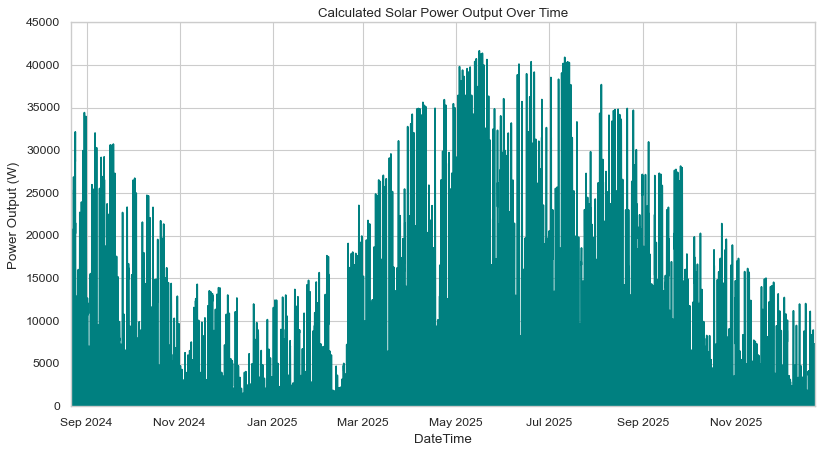

In [38]:
# Plot the calculated power output
plt.figure(figsize=(12,6))
sns.lineplot(data=df_copernicus_solar_enriched, x='DateTime', y='Total_Power_Output(W)', color='teal')
plt.title('Calculated Solar Power Output Over Time')
plt.xlabel('DateTime')
plt.ylabel('Power Output (W)')
plt.show()


__Plot 1st day of each month__

Plot 1st day of each month , the individual panels ( pane 1 and pane 2 ) , and the total for both clear sky and total. The plots are the same axis , which shows the seasonal impact of the solar radiation. In winter there is very little sun , a function of both the time of year and the orientation of the panels.  On 2025-04-01 both clear sky and standard follow a similar curve , this shows that the calculations are very similar for both set of measures

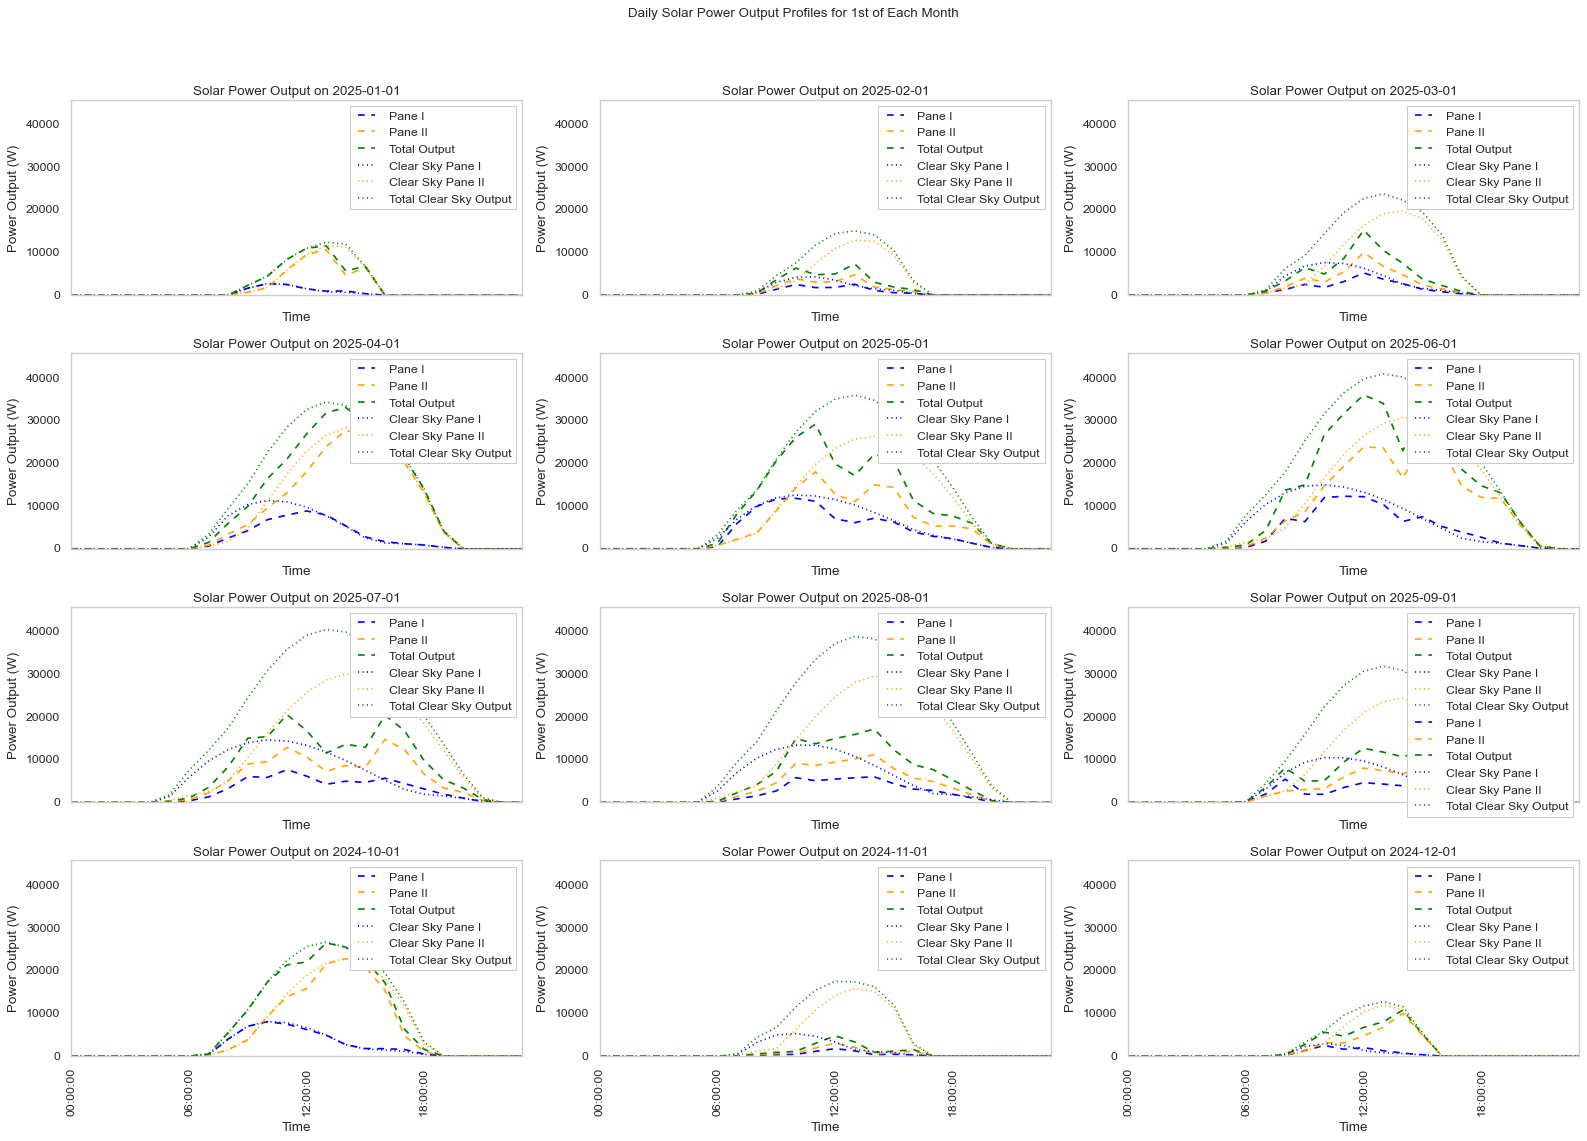

In [39]:
# Plot 1 day per month for each month include both panes and total power output
fig,ax = plt.subplots(4,3,figsize=(20,15))
df_temp = df_copernicus_solar_enriched.copy()
# Convert Time to string for plotting
df_temp['Time'] = df_temp['Time'].astype(str)
# reset index to get DateTime as column
df_temp.reset_index(inplace=True)
df_temp = df_temp[df_temp['DateTime'].dt.day == 1][['DateTime','Date','Time','Power_Pane_I(W)','Power_Pane_II(W)','Total_Power_Output(W)',
                                                    'Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)','Total_Power_ClearSky_Output(W)']].copy()
# exclude rows > date > 2025-10-01
df_temp = df_temp[df_temp['DateTime'] <= datetime.datetime(2025, 9, 1)]
plt.grid(False)
max_y_value = max(df_copernicus_solar_enriched['Total_Power_Output(W)'].max(), df_copernicus_solar_enriched['Total_Power_ClearSky_Output(W)'].max()) * 1.1
fig.suptitle('Daily Solar Power Output Profiles for 1st of Each Month')
for date in df_temp['Date'].unique():
    df_day = df_temp[df_temp['Date'] == date]
    day = df_day['DateTime'].dt.day.iloc[0]
    month = df_day['DateTime'].dt.month.iloc[0]
    year = df_day['DateTime'].dt.year.iloc[0]
    ax_idx_row = (month - 1) // 3
    ax_idx_col = (month - 1) % 3
    sns.lineplot(data=df_day, x='Time', y='Power_Pane_I(W)', ax=ax[ax_idx_row, ax_idx_col], label='Pane I',linestyle='--',color='blue')
    sns.lineplot(data=df_day, x='Time', y='Power_Pane_II(W)', ax=ax[ax_idx_row, ax_idx_col], label='Pane II', linestyle='--', color='orange')
    sns.lineplot(data=df_day, x='Time', y='Total_Power_Output(W)', ax=ax[ax_idx_row, ax_idx_col], label='Total Output', linestyle='--', color='green')
    sns.lineplot(data=df_day, x='Time', y='Power_ClearSky_Pane_I(W)', ax=ax[ax_idx_row, ax_idx_col], label='Clear Sky Pane I', linestyle=':', color='blue')
    sns.lineplot(data=df_day, x='Time', y='Power_ClearSky_Pane_II(W)', ax=ax[ax_idx_row, ax_idx_col], label='Clear Sky Pane II', linestyle=':', color='orange')
    sns.lineplot(data=df_day, x='Time', y='Total_Power_ClearSky_Output(W)', ax=ax[ax_idx_row, ax_idx_col], label='Total Clear Sky Output', linestyle=':', color='green')
    ax[ax_idx_row, ax_idx_col].set_title(f'Solar Power Output on {year}-{month:02d}-{day:02d}')
    #ax[ax_idx_row, ax_idx_col].set_xlabel('Time')
    # make sure y axis is always starts at zero
    ax[ax_idx_row, ax_idx_col].set_ylim(bottom=0)
    # and is the same for all plots using max value from entire dataframe
    ax[ax_idx_row, ax_idx_col].set_ylim(0, max_y_value)
    # Dont display x label for all but bottom plots only plot every hour
    if ax_idx_row < 3:
        #ax[ax_idx_row, ax_idx_col].set_xlabel('')
        ax[ax_idx_row, ax_idx_col].set_xticklabels([])
    else:
        #ax[ax_idx_row, ax_idx_col].set_xlabel('Time')
        # only plot 1 per hour to avoid clutter
        ax[ax_idx_row, ax_idx_col].set_xticks(ax[ax_idx_row, ax_idx_col].get_xticks()[::6])
        # rorotate x-axis labels for better readability
        ax[ax_idx_row, ax_idx_col].tick_params(axis='x', rotation=90)

    ax[ax_idx_row, ax_idx_col].set_ylabel('Power Output (W)')
    #ax[ax_idx_row, ax_idx_col].tick_params(axis='x', rotation=90)
    ax[ax_idx_row, ax_idx_col].legend()

# Ensure no grid on any subplot (both major and minor)
for axi in ax.flat:
    axi.grid(False, which='both')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

__Plot Solar Availability__

This is a summary on a weekly leavel of the total , it's interesting because in Ireland the weather during winter is very bleak


Text(0.5, 1.0, 'Weekly Solar Power Output Difference (Actual - Clear Sky)')

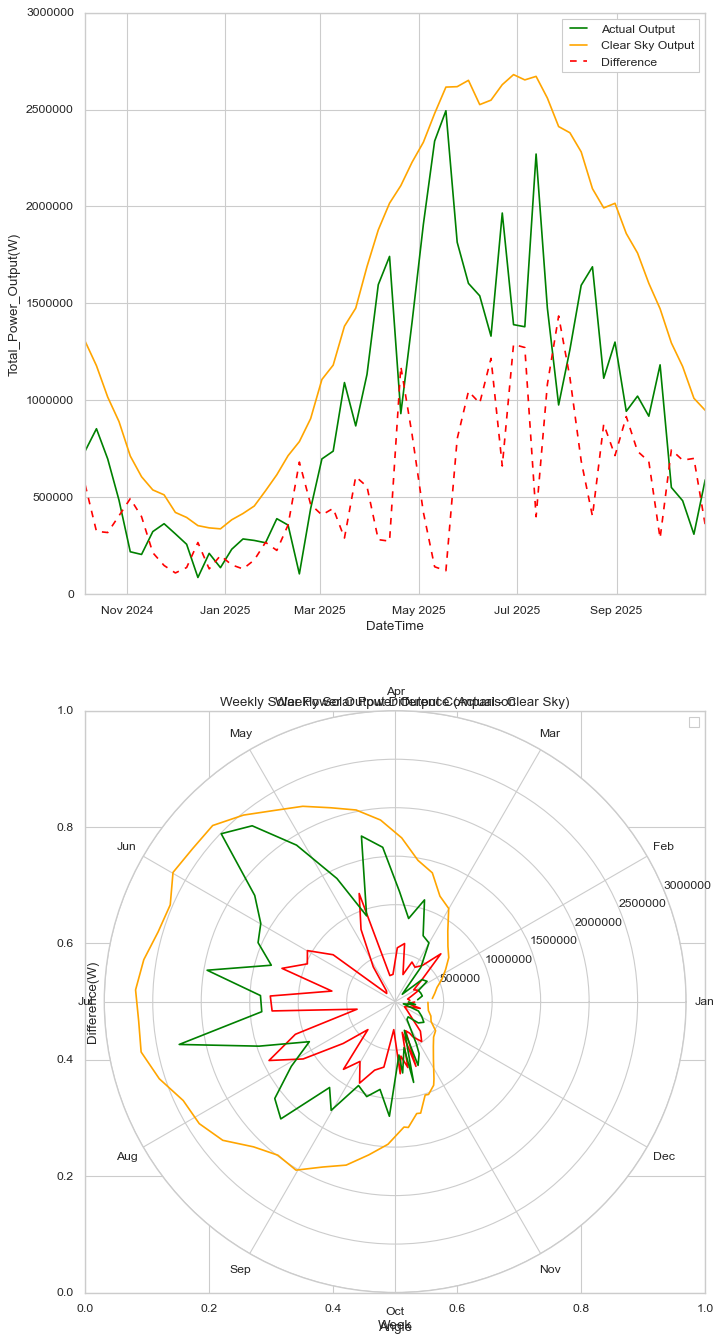

In [40]:
# Plot weekly total power output vs clear sky output
# resample to weekly sums
df_temp = df_copernicus_solar_enriched[['DateTime','Total_Power_Output(W)','Total_Power_ClearSky_Output(W)']].resample('W', on='DateTime').sum().reset_index()
# Limit between 2024-09-01 and 2025-09-30
df_temp = df_temp[(df_temp['DateTime'] >= datetime.datetime(2024, 10,1)) & (df_temp['DateTime'] <= datetime.datetime(2025, 10, 31))]
# work out the difference between actual and clear sky output
df_temp['Difference(W)'] = df_temp['Total_Power_ClearSky_Output(W)'] - df_temp['Total_Power_Output(W)']
# axis = 1 to get mean across columns 
df_temp['Mean(W)'] = df_temp[['Total_Power_Output(W)','Total_Power_ClearSky_Output(W)']].mean(axis=1)
fig,ax = plt.subplots(2,1,figsize=(10,20))

sns.lineplot(data=df_temp, x='DateTime', y='Total_Power_Output(W)', label='Actual Output', color='green', ax=ax[0])
sns.lineplot(data=df_temp, x='DateTime', y='Total_Power_ClearSky_Output(W)', label='Clear Sky Output', color='orange', ax=ax[0])
sns.lineplot(data=df_temp, x='DateTime', y='Difference(W)', label='Difference', color='red', linestyle='--', ax=ax[0])
plt.legend()
plt.xlabel('Week')
# Move title above the plot
plt.title('Weekly Solar Power Output Comparison')
# do a polar/radar plot of the difference over the year and totals
ax[1] = plt.subplot(2, 1, 2, projection='polar')
# Convert DateTime to radians for polar plot
df_temp['Angle'] = df_temp['DateTime'].dt.dayofyear * (2.0 * np.pi / 365.25)
# Plot difference and total power output
sns.lineplot(data=df_temp, x='Angle', y='Difference(W)', ax=ax[1], color='red')
sns.lineplot(data=df_temp, x='Angle', y='Total_Power_Output(W)', ax=ax[1] , color='green')
sns.lineplot(data=df_temp, x='Angle', y='Total_Power_ClearSky_Output(W)', ax=ax[1], color='orange')
# Label with month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_angles = [i * (2.0 * np.pi / 12) for i in range(12)]
ax[1].set_xticks(month_angles)
ax[1].set_xticklabels(month_names)
ax[1].set_title('Weekly Solar Power Output Difference (Actual - Clear Sky)')

## Examining Inverter Export Measurement and Utility Import Measurement

__Introduction__

The home solar system measures the energy exported to the grid (kWh), while the Utility (ESB) measures the microgeneration import (kWh). This section compares these two datasets.

Initially conceived as an audit of the measurements—essentially asking, "Am I being ripped off?"—this analysis has evolved into an interesting comparison of two distinct measurement methods applied to the same energy flow.

The data is sourced from SQLITE3 database , and either reported on , or loaded into a data frame and then analysed


![House/ESB](images/ESB_SOLAR.drawio.png)

- **Output measurement:**
  - Source: Monthly Export From Inverter
  - DataFrame: `df_raw_monthly_solar`
  - Table: weekly_solar_data
- **Input measurement:**
  - Source: ESB Microgeneration
  - DataFrame: `df_raw_esb_microgen`
  - Table: daily_esb_microgen_data



### Step 1: Audit Export Data Integrity

A critical step in our analysis is to ensure the integrity of our data sources. We will validate the solar export data by comparing measurements from the solar inverter against the official ESB smart meter readings.

**Methodology:**

The analysis involves two key tables:
1.  `weekly_solar_data`: Contains daily export data from the solar inverter, specifically the `Exported(kWh)` column.
2.  `daily_esb_microgen`: Contains daily export data from the ESB meter, found in the `Export Volume (kWh)` column.

These tables were aggregated to calculate the total exported energy from each source over the entire period.

**Results & Analysis:**

The comparison of the total summed exports is as follows:

| Data Source | Total Export |
| :--- | :--- |
| ESB Meter | 5473.47 kWh |
| Solar Inverter | 5337.72 kWh |
| **Difference** | **-135.75 kWh (-0.63%)** |

The analysis reveals a -0.63% percentage difference, with the solar inverter reporting a lower export value than the ESB meter. This result is counter-intuitive. Standard electrical principles suggest that energy losses (line losses) occur between the point of generation (the inverter) and the grid connection point (the meter). Therefore, the inverter's reading should theoretically be higher, not lower.

**Conclusion:**

While the discrepancy is small, it is unexpected. For the purpose of this analysis, we will consider the **ESB meter data as the single source of truth**, as it is the official billing-grade measurement. The slight understatement from the inverter is noted but will not be investigated further at this time.


In [41]:
csr = con.cursor()
markdown_lines = ["### Data Audit Summary Report", ""]
# get date range from daily_esb_microgen_data
markdown_lines.append("__DateTime range in daily_esb_microgen_data table:__")
csr.execute("SELECT MIN(Date), MAX(Date) FROM daily_esb_microgen_data")
result = csr.fetchone()
markdown_lines.append(f"Weather Data DateTime Range: {result[0]} to {result[1]}")
markdown_lines.append("__Date range in weekly_solar_data table:__")
csr.execute("SELECT MIN(Date), MAX(Date) FROM weekly_solar_data")
result = csr.fetchone()
markdown_lines.append(f"Solar Data DateRange: {result[0]} to {result[1]}")
# do a inner join on Date between the two tables to see overlapping dates
csr.execute("""SELECT COUNT(*),MAX(esb.Date) End_Date,MIN(esb.Date) Start_Date,MAX(esb.Date)-MIN(esb.Date) AS Date_Diff FROM daily_esb_microgen_data AS esb
               INNER JOIN weekly_solar_data AS solar
               ON esb.Date = solar.Date""")
result = csr.fetchone()
markdown_lines.append(f"__Number of overlapping dates:__ {result[0]} from {result[2]} to {result[1]} (Total Days: {result[3]})")
# Do inner join and total the Export Volume (kWh) and Exported(kWh)
csr.execute("""SELECT SUM(esb.[Export Volume (kWh)]) AS Total_ESB_Export, SUM(solar.[Exported(kWh)]) AS Total_Solar_Export
               FROM daily_esb_microgen_data AS esb
               INNER JOIN weekly_solar_data AS solar    
               ON esb.Date = solar.Date""")
result = csr.fetchone()
markdown_lines.append(f"__Total ESB Export:__ {result[0]}, __Total Solar Export:__ {result[1]}")
markdown_lines.append(f"__Difference:__ {result[1] - result[0]}")
# percent difference
percent_diff = ((result[1] - result[0]) / (result[1]+result[0])/2) * 100
markdown_lines.append(f"__Percent Difference:__ {percent_diff:.2f}%")
csr.close()
from IPython.display import display, Markdown
display(Markdown('    \n'.join(markdown_lines)))



### Data Audit Summary Report    
    
__DateTime range in daily_esb_microgen_data table:__    
Weather Data DateTime Range: 2024-09-05 to 2025-11-13    
__Date range in weekly_solar_data table:__    
Solar Data DateRange: 2024-09-11 to 2025-11-18    
__Number of overlapping dates:__ 429 from 2024-09-11 to 2025-11-13 (Total Days: 1)    
__Total ESB Export:__ 5473.468, __Total Solar Export:__ 5337.72    
__Difference:__ -135.7479999999996    
__Percent Difference:__ -0.63%

### Step 2: Investigating Difference between two sensor's

This is an exercise in examing if the two sensors are measuring accurately.  This can be viewed as comparing to assay methods against the same sample.
ALthough there may be slight differences in where the sample is taken ( line loss ) between the inverter sensor and the esb smart meter sensor , this can be views as a bias. There are a number of bias's which may account for the difference , 

-- Callibration bias - the inverter sensor job is to monitor the state of the inverter , while the smart meter sensor is to generate revenue ( bill me ) - the esb/micro gen sensor needs to be better :(
-- Location bias - the inverter sensor is 10 m earlier in the flow than the smart meter sensor
-- Tare Loss bias - the sensors need power to monitor


Feature	Inverter Sensor	Microgeneration Smart Meter  
Bias Type	Positive Bias (Over-reports)	Reference Standard (The "True" value)  
Bias Magnitude	Typically +1% to +5%	N/A (Baseline)  
Grade	Indicative (Class B or non-standard)	Revenue Grade (Class A or Class 1)  
Measurement	Gross Generation (often)	Net Generation  
Primary Goal	System Control & User Happiness	Billing & Financial Accuracy   

In [42]:
# export from the tables to a data frame for reporting , ploting and analysis
df_daily_esb_solar_merged = pd.read_sql_query("""SELECT esb.Date,
                                                    esb.[Export Volume (kWh)] AS ESB_Export_kWh, 
                                                    solar.[Exported(kWh)] AS Solar_Export_kWh
                                             FROM daily_esb_microgen_data AS esb 
                                             INNER JOIN weekly_solar_data AS solar 
                                          ON esb.Date = solar.Date
                                          """, con)
print("Daily ESB Microgen vs Solar DataFrame shape:", df_daily_esb_solar_merged.shape)
print("DataFrame info:")
print(df_daily_esb_solar_merged.info())


Daily ESB Microgen vs Solar DataFrame shape: (429, 3)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              429 non-null    object 
 1   ESB_Export_kWh    429 non-null    float64
 2   Solar_Export_kWh  429 non-null    float64
dtypes: float64(2), object(1)
memory usage: 10.2+ KB
None


__Plot the results__

The ESB and Inverter meter results are plotted over the same period. Visually both plots look the same. When the difference is plotted , then a outlier can be observed.

__Note:__

There is a outlier in the data , this was caused by a power outage on 2025-03-31.    
The next iteration , the outlier will be excluded 

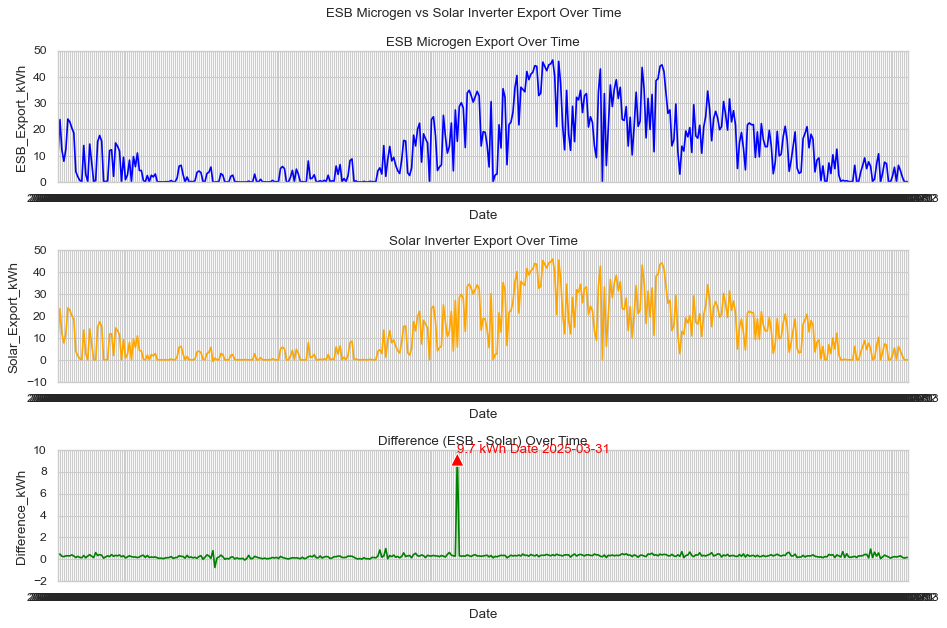

In [43]:
# Now plot each over time 
fig,ax = plt.subplots(3,1,figsize=(12,8))
fig.suptitle('ESB Microgen vs Solar Inverter Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='ESB_Export_kWh', ax=ax[0], color='blue')
ax[0].set_title('ESB Microgen Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Solar_Export_kWh', ax=ax[1], color='orange')
ax[1].set_title('Solar Inverter Export Over Time')
# calculate difference column
df_daily_esb_solar_merged['Difference_kWh'] = df_daily_esb_solar_merged['ESB_Export_kWh'] - df_daily_esb_solar_merged['Solar_Export_kWh']
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Difference_kWh', ax=ax[2], color='green')
ax[2].set_title('Difference (ESB - Solar) Over Time')
# annote arrow pointing  a point where difference is more than 5 kWh
for i, row in df_daily_esb_solar_merged.iterrows():
    if abs(row['Difference_kWh']) > 5:
        ax[2].annotate(f"{row['Difference_kWh']:.1f} kWh Date {row['Date']}", (row['Date'], row['Difference_kWh']),color='red',arrowprops=dict(facecolor='red', shrink=0.05))
plt.tight_layout()

__Reload data - exclude outliers__

The data is again loaded from the database , and outliers are excluded by using in inclusive where condition on the |Difference_kWH|  < 5. and plotted. 

In [44]:
# export from the tables to a data frame for reporting , ploting and analysis
df_daily_esb_solar_merged = pd.read_sql_query("""SELECT esb.Date,
                                                    esb.[Export Volume (kWh)] AS ESB_Export_kWh, 
                                                    solar.[Exported(kWh)] AS Solar_Export_kWh,
                                                    esb.[Export Volume (kWh)] - solar.[Exported(kWh)] AS Difference_kWh,
                                                    (esb.[Export Volume (kWh)] + solar.[Exported(kWh)])/2 AS Mean_kWh
                                             FROM daily_esb_microgen_data AS esb 
                                             INNER JOIN weekly_solar_data AS solar 
                                          ON esb.Date = solar.Date
                                              WHERE Difference_kWh < 5 AND Difference_kWh > -5
                                          """, con)
print("Daily ESB Microgen vs Solar DataFrame shape:", df_daily_esb_solar_merged.shape)
print("DataFrame info:")
print(df_daily_esb_solar_merged.info())

Daily ESB Microgen vs Solar DataFrame shape: (428, 5)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              428 non-null    object 
 1   ESB_Export_kWh    428 non-null    float64
 2   Solar_Export_kWh  428 non-null    float64
 3   Difference_kWh    428 non-null    float64
 4   Mean_kWh          428 non-null    float64
dtypes: float64(4), object(1)
memory usage: 16.8+ KB
None


__Plot Difference between ESB and Solar__

The outlier has been removed , and now the difference shows the bias. 

- The bias is positive
- Looks like a semi-normal curve

There are two types of Bias 

- fixed bias 
    - There is some fixed bias , about 0.3 kW .  This is caused by the inverter sensor is a lower grade sensor and is under reading. It is used for monitoring the health of the system , rather than esb sensor which must be a higher quality because it is used for billing. 
- proportial bias
    - There is some proportial bias which is increasing with power . 

There is some error , each sensor will have some error and as well as the data is rounded , which will also cause error. 


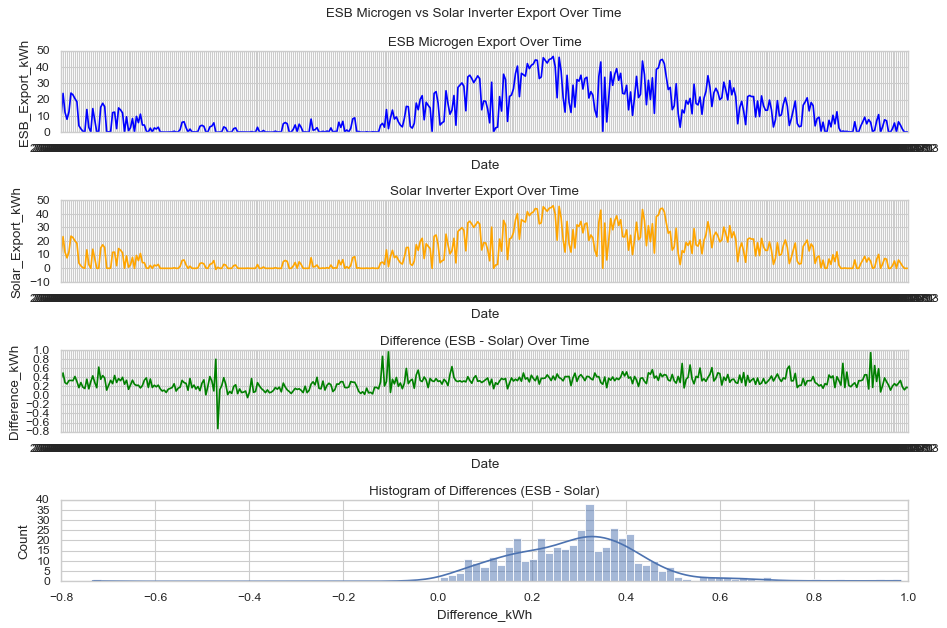

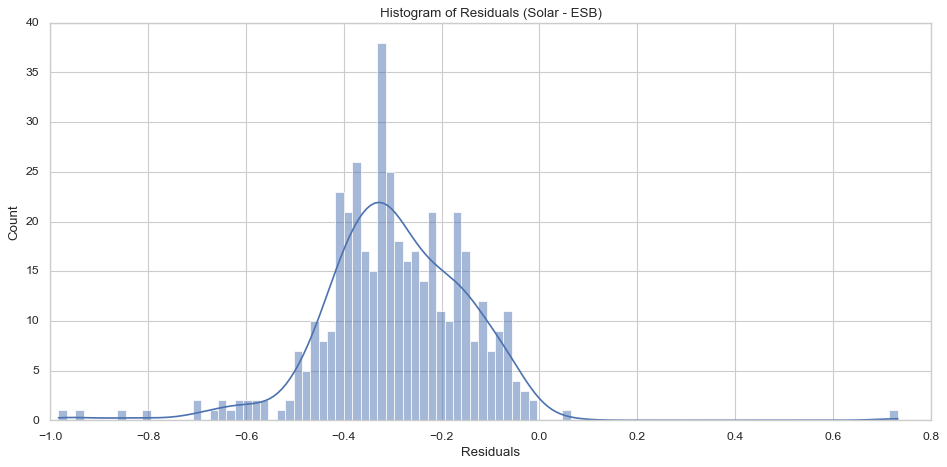

In [45]:
# Now plot each over time 
fig,ax = plt.subplots(4,1,figsize=(12,8))
fig.suptitle('ESB Microgen vs Solar Inverter Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='ESB_Export_kWh', ax=ax[0], color='blue')
ax[0].set_title('ESB Microgen Export Over Time')
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Solar_Export_kWh', ax=ax[1], color='orange')
ax[1].set_title('Solar Inverter Export Over Time')
# calculate difference column
df_daily_esb_solar_merged['Difference_kWh'] = df_daily_esb_solar_merged['ESB_Export_kWh'] - df_daily_esb_solar_merged['Solar_Export_kWh']
sns.lineplot(data=df_daily_esb_solar_merged, x='Date', y='Difference_kWh', ax=ax[2], color='green')
ax[2].set_title('Difference (ESB - Solar) Over Time')
# annote arrow pointing  a point where difference is more than 5 kWh
for i, row in df_daily_esb_solar_merged.iterrows():
    if abs(row['Difference_kWh']) > 5:
        ax[2].annotate(f"{row['Difference_kWh']:.1f} kWh Date {row['Date']}", (row['Date'], row['Difference_kWh']),color='red',arrowprops=dict(facecolor='red', shrink=0.05))
plt.tight_layout()
# plot histogram of difference
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh', bins=100, kde=True)
plt.title('Histogram of Differences (ESB - Solar)')
plt.tight_layout()
# plot residuals
df_daily_esb_solar_merged['Residuals'] = df_daily_esb_solar_merged['Solar_Export_kWh'] - df_daily_esb_solar_merged['ESB_Export_kWh']
plt.figure(figsize=(12,6))
sns.histplot(data=df_daily_esb_solar_merged, x='Residuals', bins=100, kde=True)
plt.title('Histogram of Residuals (Solar - ESB)')
plt.tight_layout()

##### Mean Bias Error

Mean Bias Error is the sume of the differences divided by the number of records

__Mean Bias Error__

$$MBE = \frac{1}{n} \sum_{i=1}^{n} (I_i - M_i)$$

$$MBE = \frac{\sum (Inverter_{kWh} - Meter_{kWh})}{TotalDays}$$

__Normalized Mean Bias Error__

$$NMBE (\%) = \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)}{(n \times \bar{y})} \times 100$$

$$NMBE (\%) = \frac{MBE}{\bar{y}_{ref}} \times 100$$


__Root mean square Error__

$$NMBE (\%) = \frac{MBE}{\bar{y}_{ref}} \times 100$$

$$RMSE = \sqrt{\frac{\sum (Inverter_{kWh} - Meter_{kWh})^2}{TotalDays}}$$


__Analysis__

Gemini Guidance

High MBE, Low RMSE: Your inverter is precise but consistently wrong (e.g., always reads +5%). This is easy to fix with a simple multiplication factor.   

Low MBE, High RMSE: Your inverter is accurate on average, but individual days fluctuate wildly (e.g., +10% one day, -10% the next). This is harder to fix and suggests synchronization issues or fluctuating efficiency.



In [46]:
markdown_lines = ["### Bias Summary Report", ""]

# calculate 
sum_of_differences = df_daily_esb_solar_merged['Difference_kWh'].sum()/df_daily_esb_solar_merged.shape[0]
# Also work out the average daily generation from solar inverter
average_solar_generation = df_daily_esb_solar_merged['Solar_Export_kWh'].sum()/df_daily_esb_solar_merged.shape[0]
markdown_lines.append(f"__Average Daily Solar Generation:__ {average_solar_generation:.4f} kWh")
markdown_lines.append(f"__Average Difference (ESB - Solar):__ {sum_of_differences:.4f} kWh")
# Now work otut the NMBE Percentage ( Normalized Mean Bias Error)
nmbe_percentage = (sum_of_differences / average_solar_generation) * 100
markdown_lines.append(f"__NMBE Percentage:__ {nmbe_percentage:.4f} %")

# now calculate the RMSE
df_daily_esb_solar_merged['Squared_Diff'] = df_daily_esb_solar_merged['Difference_kWh'] ** 2
rmse = np.sqrt(df_daily_esb_solar_merged['Squared_Diff'].mean())
markdown_lines.append(f"__RMSE (Root Mean Square Error):__ {rmse:.4f} kWh")
markdown_lines.append(f"__RMSE Percentage of Average Solar Generation:__ {(rmse / average_solar_generation) * 100:.4f} %")
markdown_lines.append(f"__Total Days Analyzed:__ {df_daily_esb_solar_merged.shape[0]} days")
markdown_lines.append(f"__Date Range Analyzed:__ {df_daily_esb_solar_merged['Date'].min()} to {df_daily_esb_solar_merged['Date'].max()}")
## Summary section
markdown_lines.append("\n---\n")
markdown_lines.append("**Summary**")
markdown_lines.append(" This is a High Precision , Low Accuracy System Comparison between the Solar Inverter and the ESB Utility Meter. ")
markdown_lines.append("The two devices differ by a consistent bias as indicated by the NMBE percentage. ")
markdown_lines.append("\n---\n")
display(Markdown('    \n'.join(markdown_lines)))

### Bias Summary Report    
    
__Average Daily Solar Generation:__ 12.4579 kWh    
__Average Difference (ESB - Solar):__ 0.2944 kWh    
__NMBE Percentage:__ 2.3634 %    
__RMSE (Root Mean Square Error):__ 0.3308 kWh    
__RMSE Percentage of Average Solar Generation:__ 2.6555 %    
__Total Days Analyzed:__ 428 days    
__Date Range Analyzed:__ 2024-09-11 to 2025-11-13    

---
    
**Summary**    
 This is a High Precision , Low Accuracy System Comparison between the Solar Inverter and the ESB Utility Meter.     
The two devices differ by a consistent bias as indicated by the NMBE percentage.     

---


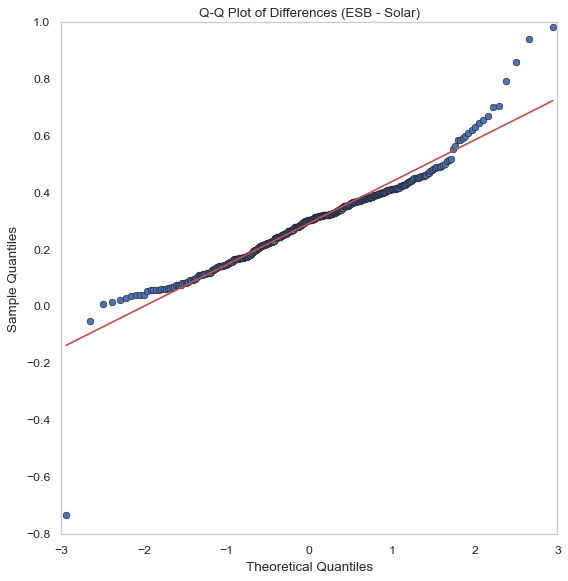

In [47]:
## Plot a q-q plot to show distribution of differences
import scipy.stats as stats
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
stats.probplot(df_daily_esb_solar_merged['Difference_kWh'], dist="norm", plot=ax)
plt.title('Q-Q Plot of Differences (ESB - Solar)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid()
plt.show()
# apply bias correction to solar inverter data and write to new table


#### Plot Difference distribution with BIAS



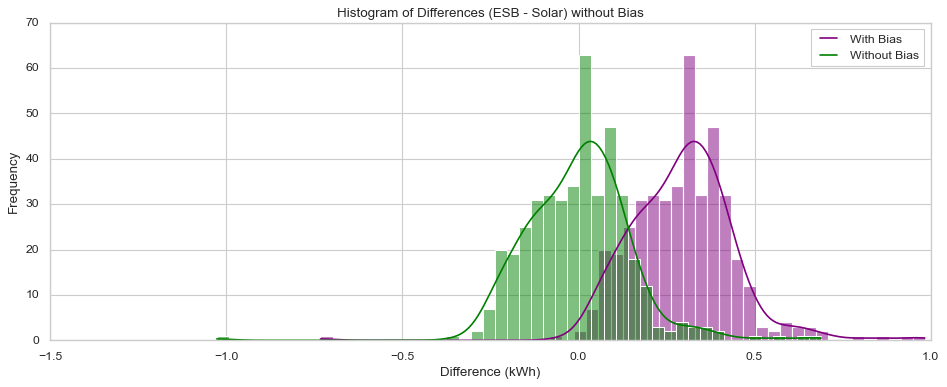

In [48]:
# Plot the histogram of differences , with and without bias on the same plot
fig ,ax = plt.subplots(1,1,figsize=(12,5))
# First plot histogram of differences with bias
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh', bins=50, kde=True, color='purple', ax=ax)
ax.set_title('Histogram of Differences (ESB - Solar) with Bias')
ax.set_xlabel('Difference (kWh)')
ax.set_ylabel('Frequency')
# Now plot histogram of differences after removing bias
df_daily_esb_solar_merged['Difference_kWh_No_Bias'] = df_daily_esb_solar_merged['Difference_kWh'] - sum_of_differences
sns.histplot(data=df_daily_esb_solar_merged, x='Difference_kWh_No_Bias', bins=50, kde=True, color='green', ax=ax)
ax.set_title('Histogram of Differences (ESB - Solar) without Bias')
ax.set_xlabel('Difference (kWh)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.legend(labels=['With Bias','Without Bias'])
plt.show()

### Bland-Altman Plot


The Bland-Altman plot is used to visually identify if there are any issues between the two sensors. The difference is plotted again the mean of the two measures. It is used to identify the bias , and visually compare the error.  The bias can either be a proportional bias or a systemic bias.  
This bias looks like a function of both , proportional bias because the trend line is increasing , and systemic bias because the line is offset..



[Wiki Band Altman Plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot)
[Seaborn Regression Plot](https://seaborn.pydata.org/generated/seaborn.regplot.html)

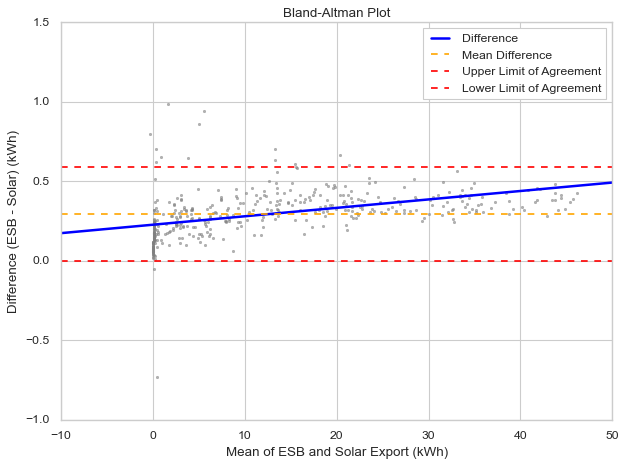

In [49]:
# Bland altman plot
fig , ax = plt.subplots(1,1,figsize=(8,6))
# use a regression plot with scatter points and a line for mean and limits of agreement

#sns.scatterplot(data=df_daily_esb_solar_merged, x='Mean_kWh', y='Difference_kWh', ax=ax)
sns.regplot(data=df_daily_esb_solar_merged, x='Mean_kWh', y='Difference_kWh', ax=ax, 
            scatter=True, ci=None,truncate=False,
             line_kws={'color':'blue','label':'Difference'},
             scatter_kws={'color':'gray','s':5,'alpha':0.6} )
mean_diff = df_daily_esb_solar_merged['Difference_kWh'].mean()
std_diff = df_daily_esb_solar_merged['Difference_kWh'].std()
ax.axhline(mean_diff, color='orange', linestyle='--', label='Mean Difference')
ax.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', label='Upper Limit of Agreement')
ax.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', label='Lower Limit of Agreement')
ax.set_title('Bland-Altman Plot')
ax.set_xlabel('Mean of ESB and Solar Export (kWh)')
ax.set_ylabel('Difference (ESB - Solar) (kWh)')
ax.legend()
plt.tight_layout()

#### Other plots

Look into wilcox

https://seaborn.pydata.org/generated/seaborn.histplot.html
https://seaborn.pydata.org/generated/seaborn.boxplot.html
https://seaborn.pydata.org/generated/seaborn.violinplot.html


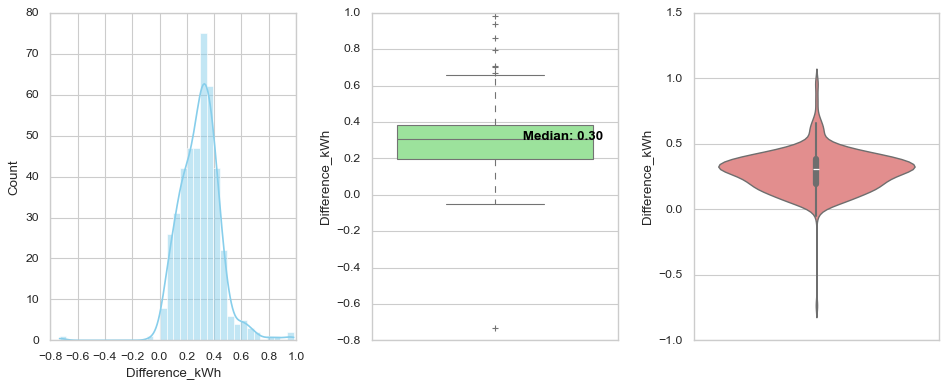

In [50]:
# 2. Create the Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
# Plot zero difference historgram
sns.histplot(df_daily_esb_solar_merged['Difference_kWh'], kde=True, ax=axes[0], color='skyblue' )
sns.boxplot(y=df_daily_esb_solar_merged['Difference_kWh'], ax=axes[1], color='lightgreen')
sns.violinplot(y=df_daily_esb_solar_merged['Difference_kWh'], ax=axes[2], color='lightcoral')
# add note of median
median_val = df_daily_esb_solar_merged['Difference_kWh'].median()
axes[1].text(0.1, median_val, f' Median: {median_val:.2f}', 
             color='black', weight='bold', ha='left')
plt.tight_layout()
plt.show()

## Predicting Solar Output from Weather

The object of this part of the project is to use numerical methods to predict the solar panel output based on weather data.

There are four sources 
 
- Target
    - Solar Panel System Power
- Source
    - Weather Meteostat
    - Solar Radiation CAS
    - Solar Power Enriched PVLIB

Random Forest will be used  to try and predict the solar panel ( PV Photovoltaic ) output based on a number of weather and solar(sun) features , such as temperature , humidity and available sunlight.  Random forest is a ensemble learning techique . It generates lots of little decision trees ( a forrest) , trains the little tree's . The results of the little trees are aggregated into the most likely goal. 

The following steps will be done

-  Data Preparation
    - Merge the data sets together
-  Apply Random Forest
    - Run various feature Combinations
    - 
    - 
| Test | Description | Train - RMSE | MAE | R^2 | N-MRSE (%) | N-MAE (%) | Accuracy % | Test - RMSE | MAE | R^2 | N-MRSE (%) | N-MAE %) | Accuracy % | Note |
|------|-------------|-------------|--------|--------|--------|---------|------------|--------------|--------|--------|------------|-------|------------|------|
| 01   | Standard    | 299.64      | 202.99 | 0.9565 | 3.5672 | 2.24165 | 87.2517    | 649.53       | 448.16 | 0.7900 | 7.7325 | 5.3352 | 73.8262 | This includes all measures |
| 02   | Temperature Only    | 1094.90     | 795.111| 0.4906 | 12.2012 | 9.4656 | 50.0641    | 1435.44      | 1111.55 | -0.0273 | 17.1004 | 13.2328 | 35.0825 | Not very good |
| 03 | Temp and Humidity | 615.54 | 445.72 | 0.8162 | 7.3278 | 5.4253 | 71,3788 | 1144.56 | 877.58 | 0.3478| 13.625 | 10.4474 |  48.7472 | Note |
| 04 | All Weather | 389.31 | 273.79 | 0.9265 | 4.6346 | 3.2594 | 82.805 | 879.38 | 636.92 | 0.6150 | 10.4689 | 7.5824 | 62.8023 | 
| 05 | All weather + panel 1 & 2 clear sky | 281.85 | 188.52 | 0.9615 | 3.3554 | 2.2443 | 88.1602 | 651.89 | 445.01 | 0.7884 | 7.7606 | 5.2978 | 74.0101 | 

.
.
.
          

| Test | Measures  | Notes |
|------|----------------|-------|
| 01 | Total_Power_ClearSky_Output , Humidity , Condition Code , Temperature , HourOfDay , Month | This is the best combination clear sky represents the total sun output without clouds , humidity & temperature represent the "cloudiness" , Month the season and hour of day  indirectly is a proxy for sun output |
| 02 | Temperature | Temperature Only
| 03 | Temperature + Humidity | Humidity is the main feature being used - represents clouds
| 04 | Temperature , Humidity , Condition Code , Month , Day of Year , Hour Of Day | This covers all the "standard weather data"
| 05 | Temperature , Humidity , Condition Code , Month , Day of Year , Hour Of Day , Clear Sky Panel I , Clear Sky Panel II | This is all weather + solar panel set I and 2 | the Panel II , Condition Code and Humidity are the features with the most importance 


__RMSE - Root Mean Square Error__


RMSE stands for Root Mean Squared Error. It is the standard metric for measuring error in regression models (like your solar forecaster) because it tells you how "spread out" your prediction errors are. In this case the RMSE is 649 W or 7.7 Percent

[RMSE](https://statisticsbyjim.com/regression/root-mean-square-error-rmse/)
$$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }$$


Where:  $n$ = Number of samples (hours)     
        $y_i$ = Actual PV Output (Watts)   
        $\hat{y}_i$ = Predicted PV Output (Watts)   

__N-RMSE - Normalized Mean Square Error__

Industry Benchmarks: Generally in solar forecasting:

< 5% Error: Excellent state-of-the-art.

5% - 10% Error: Very good, commercially useful.

10% - 15% Error: Decent, but room for improvement (often due to highly variable weather... like Ireland!).

> 15%: Likely needs model tuning or better weather data.

$$nRMSE = \frac{RMSE}{C_{installed}} \times 100$$

[RMSE](https://www.deepchecks.com/glossary/root-mean-square-error/#:~:text=RMSE%20%3D%20sqrt%20%5B(%CE%A3(Pi,Oi)%C2%B2)%20%2F%20n%5D&text=This%20calculation%20serves%20as%20a,the%20values%20observed%20in%20reality.)
[RMSE Google](https://developers.google.com/machine-learning/crash-course/linear-regression/loss)


__ MAE - Mean Absolute Error __

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

Unlike RMSE, MAE gives the 'average' error in a way that is easier to interpret intuitively (e.g., 'On average, the prediction is off by 494 Watts').   


__ n-MAE - Normalized Mean Absolute Error __

$$nMAE = \frac{MAE}{C_{installed}} \times 100$$

Where:  $|...|$ = Absolute value (turns negatives into positives)    
$n$ = Number of samples    
$y_i$ = Actual PV Output
$\hat{y}_i$ = Predicted PV Output

[Random Forrest DataCamp](https://www.datacamp.com/tutorial/random-forests-classifier-python)   
[Random Forrest Wiki](https://en.wikipedia.org/wiki/Random_forest)   
[Good Overall Reference for approach][https://pmc.ncbi.nlm.nih.gov/articles/PMC9505493/#:~:text=To%20determine%20the%20subset%2C%20we,dataset%20into%20balanced%20data%20subsets.]
[Forcasting Solar using Random Forrest](https://www.sciencedirect.com/science/article/abs/pii/S0960148116311648)
[Forecast Solar using Random Forrest](https://univ-corse.hal.science/hal-01426321v1/document)

__Observation__

The measures/features plotted againt PV(W) output can be broken down into a number of groups

- Tempurature
    - This should be inversely proportional to PV(W) because PV become more efficient at lower temperatures
    - The graph shows a positive relationship between temp and PV(W) , I suspect that in Ireland the warmer it is , the more sunshine
- Humidity
    - This shows a negative relationship between humidity and PV(W) , I believe there are two factors , the "thicker" the air more light is observers , and also the higher the humidity the more like is it's raining.
- Time
    - The time of day is sin centered around mid day , thus the extremes represent early morning/night and late afternoon and night , the curve tends to show this
- Solar
    - This is all the solar output measures group together , the relationship is posive which makes sense since this is indicative of more sunshine :)

Also note the bar at the top of most of the plots , that represents MAX power output - in theory 8400 , but in reality it is about 5500 . This is due to panel configuration

### Predicting Solar Output using Random Forrest and Weather Data

In this section , the Random Forrest Regression will be used to determine the solar output based on the weather data. The weather data features include temperature , humidity  and clear sky solar output . There are a number of clear sky varations , the original clear sky solar output which is based on the sun hitting the ground , and the adjusted or enriched clear sky solar output based on the solar panel orientation. 

Random Forrest techinque is a enseble method , lot's of little decision tree's are agreagated together to form a forrest and overall make a beter prediction. The trees are first trained then split.

Initially the project was using the data at a 10 minute interval , which was taking to long and proved to be in-accurate.  The current method summaries the data to an hourly grain. 

Multiple variations of features will be tried to see the output and find the best variation of features. This notebook will contain the a example of the "best" setting , the main development and support notebook is [big_project_random_forrest_hourly.ipynb](big_project_rand_forest_hourly.ipynb)

[SCIKIT Learn - Random Forrest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

[Shelf learning - Random Forrect](https://shelf.io/blog/random-forests-in-machine-learning/)   

[Google - Random Forrest](https://developers.google.com/machine-learning/decision-forests/random-forests)

[SCIKIT Learn - train_test_Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [110]:

feature_cols = ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'GHI',
                'Total_Power_Output(W)', 'Power_Pane_I(W)', 'Power_Pane_II(W)','Clear sky GHI',
                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
target_col = 'PV(W)'
hour_night_threshold = 50  # This is thethreshold to Total_Power_ClearSky_Output(W) below which it is considered nighttime

__Function: test_random_forrest__

This function processes different combinations of features and applies the Random Forest algorithm to predict solar panel output (PV(W)). It:

1. **Prepares data**: Splits features and target into training and testing sets
2. **Trains model**: Creates and trains a Random Forest regressor with specified hyperparameters
3. **Evaluates performance**: Calculates metrics (MSE, R², MAPE) to assess prediction accuracy
4. **Returns results**: Provides model object and performance metrics for comparison across different feature sets

The function enables systematic testing of various feature combinations to identify which weather and solar variables are most effective for predicting inverter output.


![Function Flow](images/ESB_SOLAR-Random_Forrest.drawio.png)

#### Data Preparation

The following sets of data will be loaded from previously prepared data. This gives versatility in process in a seperate notebook.
The 3 data sources are used


| Data Source | Type | Name | Notes |
|-------------|------|------|-------|
| PV/Solar Data | Target | Daily Solar Data | This is the data from solaris domenstic solar system |
| Weather | Source | Weather Data | This is the weather data which include temp, humidity and solar output |
| Solar   | Source | Solar/Sun Weather Data | This is the solar terestrial data from copernicus satalite data enriched with analysis from pvlib |


The following process is followed

- data is loaded from source files in feather format
- data is aggregated/grouped to a hourly level
- additional columns are added

__Notes:__

The weather data is the actual weather data on the day , although in reallity weather predictions will be used the concept will be the same. 


Setup file names

In [131]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"



Load files into data frames

In [132]:
import pandas as pd
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_data)


# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_weather_data.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_weather_data.columns.tolist() if level.startswith('level2_')]

Show column names


In [133]:
# Show the columns/features and data types for each dataset using pandas DataFrame
import seaborn as sns
sns.set_theme()
feature_columns = {
    "Enriched Features": df_enriched_features.columns,
    "Weather Data": df_weather_data.columns,
    "Solar Data": df_solar_data.columns,
}
for title, cols in feature_columns.items():
    print(f"\n{title} Columns and Data Types:")
    display(pd.DataFrame({"Columns": cols, "Data Types": eval(f"df_{title.lower().replace(' ', '_')}").dtypes}))


Enriched Features Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
# Observation period,# Observation period,object
TOA,TOA,float64
Clear sky GHI,Clear sky GHI,float64
Clear sky BHI,Clear sky BHI,float64
Clear sky DHI,Clear sky DHI,float64
Clear sky BNI,Clear sky BNI,float64
GHI,GHI,float64
BHI,BHI,float64
DHI,DHI,float64



Weather Data Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
Sunshine Duration,Sunshine Duration,Float64
Condition Code,Condition Code,Float64
Precipitation(mm),Precipitation(mm),Float64
Dew Point(C),Dew Point(C),Float64
Wind Direction(deg),Wind Direction(deg),Float64
Wind Speed(m/s),Wind Speed(m/s),Float64
Wind Gust(m/s),Wind Gust(m/s),Float64



Solar Data Columns and Data Types:


,Columns,Data Types
Date,Date,object
Number,Number,int64
Time,Time,object
Working State,Working State,object
PV(W),PV(W),float64
Battery(W),Battery(W),float64
Grid(W),Grid(W),float64
Load(W),Load(W),float64
SOC(%),SOC(%),float64
Total_Yield(kWh),Total_Yield(kWh),float64


Change granularity to hourly

Aggregate the granularity to hourly , using either sum , mean or first. 

In [134]:
# change all the 3  to an hourly aggregation using resample
print(df_enriched_features.columns.to_list())
df_solar_per_hour = df_solar_data[['PV(W)','DateTime']].resample('h', on='DateTime').agg('mean')
# weather is now hourly so just copy
df_weather_per_hour = df_weather_data.copy()
# 'DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)'
df_enriched_per_hour = df_enriched_features.copy()

['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)']


Add additonal columns and filtered out Nan

| Column | Description |
|--------|-------------|
| WeekOfYear | The week no within the year 1-52/3 |
| Month_Sin | Sine of Month - a form of normalization |
| DayOfYear_Sin | Sine of Day Number in year - a form of normalization |
| HourOfDay_Sin | Sine Of Hour of Day |

There are some rows with the target value ( PV(W)) of Nan (NULL) , random forrest cannot handle a target value of Nan



In [135]:
import numpy as np
# Merge the three dataframes on DateTime
df_merge_hourly = df_solar_per_hour.merge(df_weather_per_hour, on='DateTime').merge(df_enriched_per_hour, on='DateTime')
df_merge_hourly.reset_index(inplace=True)
# Add WeekOfYear
df_merge_hourly['WeekOfYear'] = df_merge_hourly['DateTime'].dt.isocalendar().week
df_merge_hourly['Month_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.month - 1) / 12)
df_merge_hourly['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.dayofyear - 1) / 365)
df_merge_hourly['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.hour) / 24)
df_merge_hourly['Hour'] = df_merge_hourly['DateTime'].dt.hour
# Count number Nan in target Y column
print("Number of NaN in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
# Remove Nan in target Y column
df_merge_hourly = df_merge_hourly.dropna(subset=['PV(W)'])
# Count number of rows after removing NaN
print("Number of NaN  after removing in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
print("Number of rows after removing NaN in PV(W):", len(df_merge_hourly))
print("Dataframe shape after removing NaN in PV(W):", df_merge_hourly.shape)
# delete rows where PV(W) is less than threshold
df_merge_hourly = df_merge_hourly[df_merge_hourly['PV(W)'] >= hour_night_threshold]
print("Number of rows after removing night time data in PV(W):", len(df_merge_hourly))
print("Dataframe shape after removing night time data in PV(W):", df_merge_hourly.shape)
# create an alterative target clearsky index
df_merge_hourly['Clearsky_Index'] = df_merge_hourly['PV(W)'] / df_merge_hourly['Total_Power_ClearSky_Output(W)']
# create new measure wind cooling
df_merge_hourly['Wind Cooling'] = df_merge_hourly['Temperature(C)'] * df_merge_hourly['Wind Speed(m/s)'] 

Number of NaN in PV(W): 413
Number of NaN  after removing in PV(W): 0
Number of rows after removing NaN in PV(W): 9981
Dataframe shape after removing NaN in PV(W): (9981, 62)
Number of rows after removing night time data in PV(W): 4792
Dataframe shape after removing night time data in PV(W): (4792, 62)


Show dataframe column format

In [136]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
DayOfYear_Sin,DayOfYear_Sin,float64
HourOfDay_Sin,HourOfDay_Sin,float64
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64


__Solar Output and Weather Featues__

This is a plot of the Clear sky GHI and PV(W) again weather to see if there are any interesting observations.

1. The Scaled Clear SKY  ( Blue ) shows the same shape as Scaled PV(W) ( Grean) , except it is slightly "larger" , this could be due PV efficiency either do to dirt , shade or PVLIB .  The difference get's greater the higher the GHI is. 
2. Thermal Lag - PV panels loose there efficiencie with temperature , thus even though the Sunlight may be the same in the morning and in the afternoon , the higher afternoon temperature and the panels heating up , reduces the efficiency of the solar panels
3. Morning Chaos - Between 0-6 am there is a lot of variation ( width of red section) in the weather feature. This is a feature of Irish Weather
4. Wind Cooling - solar panel are more efficient when there is a wind cooling effect. 

A suggested feature is too combined windspeed and temperature. 

Gemini Prompt of images below  

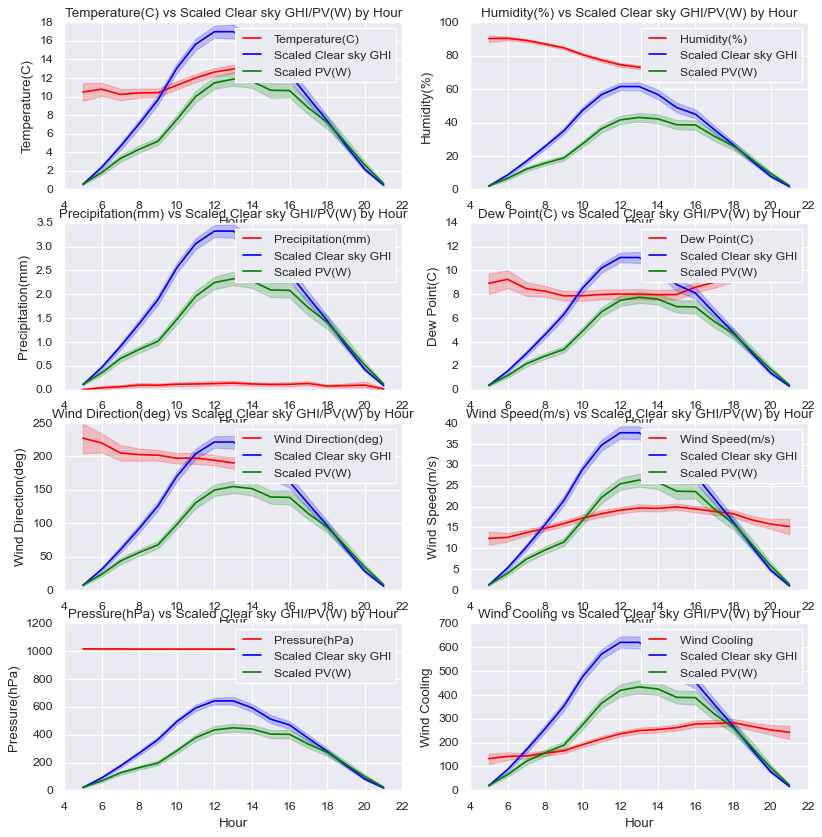

In [137]:
# Plot Temperature Mean vs Clear sky GHI Mean against Hour of Day ,scale the two to fit on same plot
fig,axes = plt.subplots(4,2,figsize=(12,12))

# flatten ax
axes = axes.flatten()
i = 0
feature_temp = ['Temperature(C)','Humidity(%)','Precipitation(mm)','Dew Point(C)','Wind Direction(deg)','Wind Speed(m/s)','Pressure(hPa)','Wind Cooling']
for ax in axes:
    if i<len(feature_temp):
        feat = feature_temp[i]
        i = i + 1
    else:
        break
    sns.lineplot(data=df_merge_hourly, x='Hour', y=feat, label=feat, color='red',ax=ax)
    # scale Clear sky GHI to temperature range
    scaled_clear_sky_ghi = (df_merge_hourly['Clear sky GHI'] / df_merge_hourly['Clear sky GHI'].max()) * df_merge_hourly[feat].max()
    scaled_pw = (df_merge_hourly['PV(W)'] / df_merge_hourly['PV(W)'].max()) * df_merge_hourly[feat].max()
    sns.lineplot(data=df_merge_hourly, x='Hour', y=scaled_clear_sky_ghi, label='Scaled Clear sky GHI', color='blue',ax = ax)
    sns.lineplot(data=df_merge_hourly, x='Hour', y=scaled_pw, label='Scaled PV(W)', color='green',ax=ax)
    ax.set_title(f'{feat} vs Scaled Clear sky GHI/PV(W) by Hour')
plt.legend()
plt.show()

__The Clear Sky Index (k) and Model Performance__

This is an explanation of the Clear Sky Index ($k$) and why using it improves the machine learning model performance. This changes the time dependent PV(W) , to a less time dependend Clear Sky Index

$$k = \frac{\text{Actual Power Output}}{\text{Theoretical Clear Sky Power}}$$

* **$k \approx 1.0$ (Max Efficiency):** It is a perfect sunny day. The atmosphere is transparent.
* **$k < 1.0$:** Something is blocking the light (clouds, rain, fog).
* **$k > 1.0$:** "Cloud Edge Effect" (reflection from nearby clouds) or efficiency boosts from cold/windy conditions.

1. **The Function** - The index is effectively a "Performance Score" for the atmosphere. It is a simple ratio of the power you *actually* produced divided by what you *theoretically could have* produced on a perfect sunny day.
2. **The Bell Curve Trap** - If you predict raw PV Power (Watts), the data looks like a rollercoaster (up in the morning, down in the evening). The Random Forest has to waste effort learning basic astronomy just to know that power is low at 6 AM and high at 12 PM.
3. **The Solution** - By dividing by the Clear Sky model, you remove the sun's movement from the equation. The target becomes a "Flat Line" that stays steady around your max efficiency and only dips when a cloud appears.
4. **Why Random Forests Love It** - Models like "Stationary Data" that looks the same over time. Without the index, "Rain" means 50W at 8 AM but 500W at 12 PM, which confuses the model. With the index, "Rain" just means 40% efficiency, regardless of what time it is.

A suggested approach is to use the index so the physics model handles the sun's position, leaving the machine learning model to focus on the weather.


__Interesting__

The spike at 4pm is caused by the orientation of the 11 panels WSW , these panels are "super" charged by the afternoon sun.

__References__
1. Duffie, J. A., & Beckman, W. A. (2013). *Solar Engineering of Thermal Processes*.
2. Liu, B. Y. H., & Jordan, R. C. (1960). *Solar Energy*.
3. Badescu, V. (2008). *Modeling Solar Radiation at the Earth's Surface*.

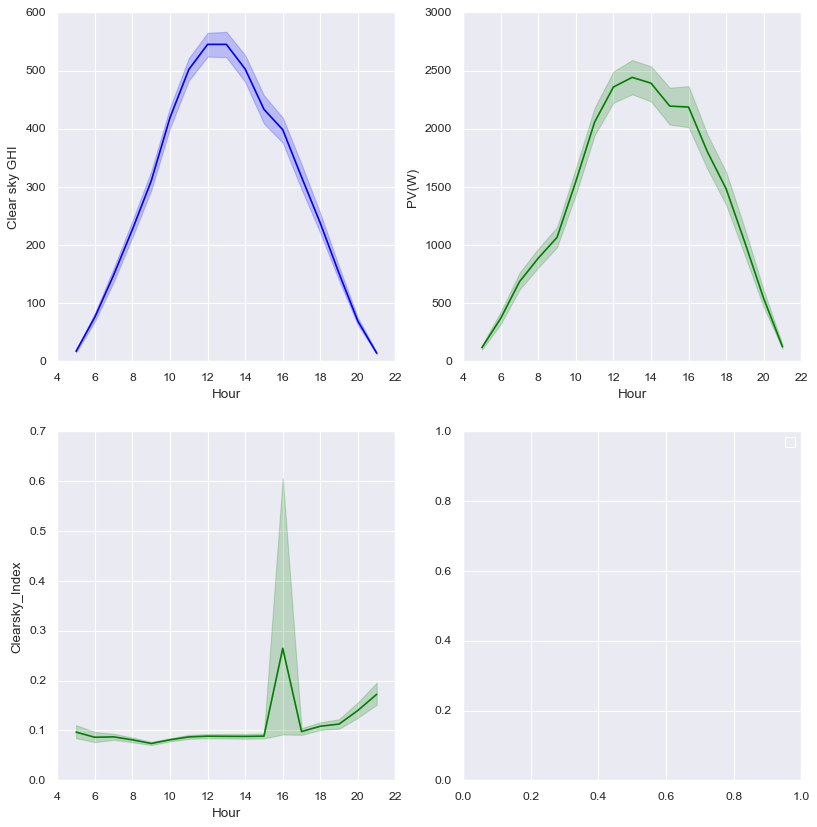

In [138]:
# Plot Temperature Mean vs Clear sky GHI Mean against Hour of Day ,scale the two to fit on same plot
fig,axes = plt.subplots(2,2,figsize=(12,12))

# flatten ax
ax = axes.flatten()
sns.lineplot(data=df_merge_hourly, x='Hour', y='Clear sky GHI',  color='blue',ax = ax[0])
sns.lineplot(data=df_merge_hourly, x='Hour', y='PV(W)', color='green',ax=ax[1])
sns.lineplot(data=df_merge_hourly, x='Hour', y='Clearsky_Index', color='green',ax=ax[2])
plt.legend()
plt.show()

__Prepare Data Sets for Training and Testing__

There is some discrepency on how to split solar data , the data is time series data and if active prediction was being done then the time series order would be important. Active prediction is when the output needs to be predicted this hour based on the previous hours data. Random Forrest and XBOOST are stateless , what is meant is that the prediction is dependent on the current data only. 

The data will be split as follows

- training will be odd weeks
- test will be be even weeks

__Note :__ It is recommended that the data be split into 3 - training week , test week and gap week . This is too prevent data leakage and overfitting . 



[Split Cons IBM ](https://www.ibm.com/think/topics/data-leakage-machine-learning#:~:text=Data%20leakage%20happens%20when%20data,production%2C%20it%20becomes%20entirely%20inaccurate.)    
[Split Cons KAGGLE](https://www.kaggle.com/discussions/getting-started/551515)   
[Split Pro](https://pmc.ncbi.nlm.nih.gov/articles/PMC9505493/#:~:text=To%20determine%20the%20subset%2C%20we,dataset%20into%20balanced%20data%20subsets.)
[Forecasting:Principles and Practice](http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20collection%20-%202025/MED/Forecasting_%20Principles%20and%20Practice.pdf)

In [139]:
print("Columns:", df_merge_hourly.columns.tolist())#
#feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin',
#                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Month_Sin',  'HourOfDay_Sin', 
                'Total_Power_ClearSky_Output(W)']
feature_cols.extend(level1_features)
target_col = 'PV(W)'
print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# first we filter  out where the output is less than threshold - to avoid night time data , this is based on clearsky GHI
df_daytime = df_merge_hourly['Clear sky GHI'] > 10
# now split into test and training based test and train data sets are every other week
df_daytime_train = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 0) & (df_daytime)]
df_daytime_test = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 1) & (df_daytime)]
print("Training DataFrame shape:", df_daytime_train.shape)
print("Testing DataFrame shape:", df_daytime_test.shape)
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]


Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky

__Random Forrest Training and Prediction __

In [140]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=16,min_samples_split=5,min_samples_leaf=2)
# Train the model
print("Fitting model...")
rf_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_test_pred = rf_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
print("Making predictions on training set...")
y_train_pred = rf_model.predict(X_train)
print("Making predictions on training set... Done")
      

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...
Making predictions on training set... Done


In [141]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    #normalization_factor = np.max(y_true) 
    normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown("### Random Forest Regressor Performance Metrics\n" + mk_string))
#print(f"\nTraining Metrics:\nRMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}, Accuracy: {train_accuracy:.4f}")
#print(f"\nTesting Metrics:\nRMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}, Accuracy: {test_accuracy:.4f}")
# feature importance plot
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


### Random Forest Regressor Performance Metrics
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 321.00              | 670.20              |
| MAE          | 221.80              | 468.46              |
| R2           | 0.9496              | 0.7722              |
| N-RMSE (%)   | 3.8215              | 7.9785              |
| N-MAE (%)    | 2.6405              | 5.5769              |
| Accuracy (%) | 86.6101              | 73.6645              |

__Important Features__:

This plots the features and there importance to the random forrest model.  This is a list of the features and how much the feature contributes the model. The Total Power ClearSky Output(W) is the amount of sunlight available without clouds. This is a positive feature , and is the maximum power available , the othe other features can be viewed as subtractive . Humidity is a proxy for clouds , Is a scale relating to what type of weather is present 0 ( nice day - never happens) - 10 ( RIP ) , temperature - the colder it is , the more cloudy it is . The month is a proxy for how much light there is in the year / and cloudiness , and hour represents daily light cycle. The Total Power is the most important because it is the base.


[Importance - Elastic](https://www.elastic.co/docs/explore-analyze/machine-learning/data-frame-analytics/ml-feature-importance)    
[Importance - Towards Data Science](https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660/)    

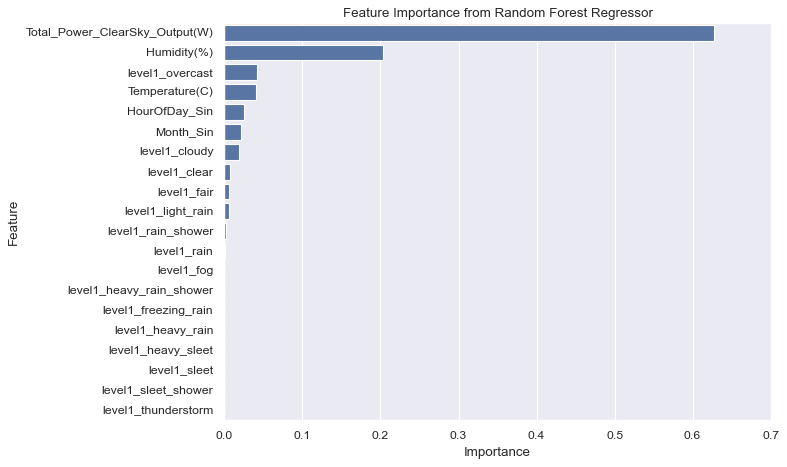

In [142]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

__Ridiuals vs Actual Plot

This plots the riduals ( actual - predicted) against actual. The shape is Heteroscedasticity or Fan Shaped , as the values grow larger , so does the error. Also at the higher end 6000 Watt the ceil the model underpredicts , because that level is rarely reached ( this is ireland ) , this is where the solar system max's out , it cannot product more power even if there is more sun.



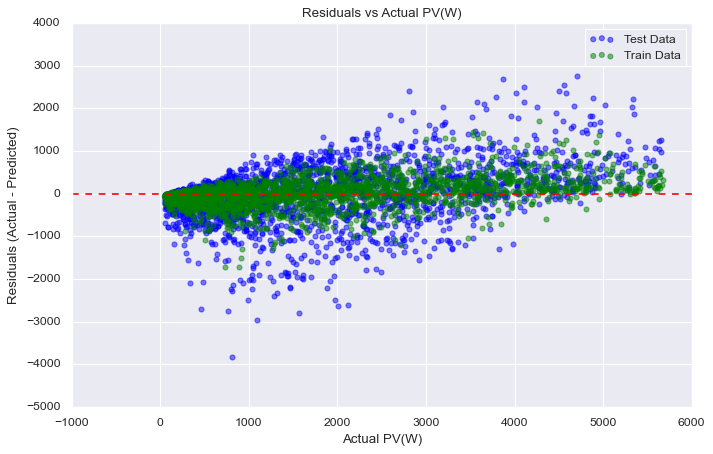

In [143]:
# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


__Plot of Residuals vs Hours of Day__

Similar too the above graph , this has a football shape , as the the time approachs midday , the higher the sun output , the bigger the error. 


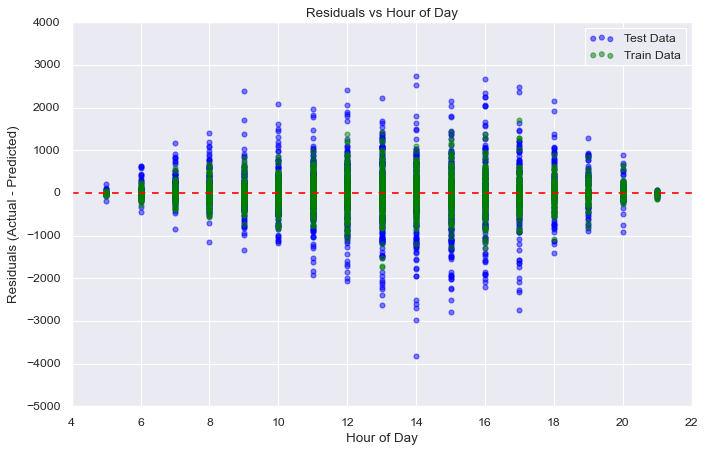

In [144]:
# plot risduals per hour of day
plt.figure(figsize=(10,6))
plt.scatter(df_daytime_test['DateTime'].dt.hour, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(df_daytime_train['DateTime'].dt.hour, y_train - y_train_pred
, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

__Plot Average Day Residual VS Date__

This is used to show if there is an auto-correlation issue . In this case it is not showing a auto-correlation issue because the average day issue risual is all over the place , it is showing that there might be a feature missing. I suspect I need a prediction of cloud cover. 

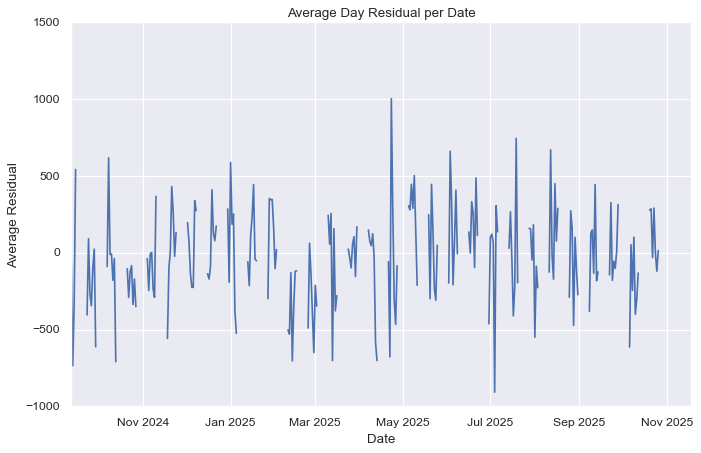

In [145]:
# Plot average day residual per date
import matplotlib.pyplot as plt
df_daytime_est = df_merge_hourly.copy()
df_daytime_est['Residuals'] = y_test - y_test_pred
df_daytime_est['Date'] = df_daytime_est['DateTime'].dt.date

average_residuals = df_daytime_est.groupby('Date')['Residuals'].mean()

plt.figure(figsize=(10, 6))
average_residuals.plot()
plt.xlabel('Date')
plt.ylabel('Average Residual')
plt.title('Average Day Residual per Date')
plt.show()

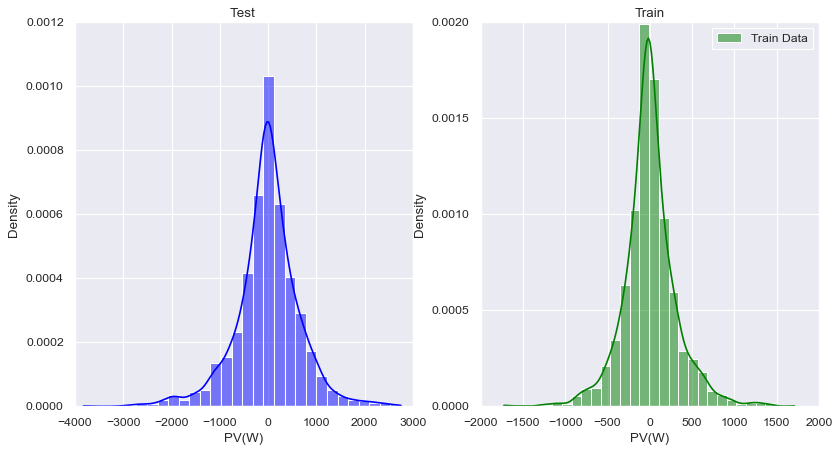

In [146]:
# Residual histogram
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_title('Test ')
sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, stat="density", bins=30,ax=ax[0])
ax[1].set_title('Train')
sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, stat="density", bins=30,ax=ax[1])

plt.legend()
plt.show()

__Q Q Plot__

This is an example of a heavy tail.  The model handles daily fluctuations well , but it does not handle outliers well.

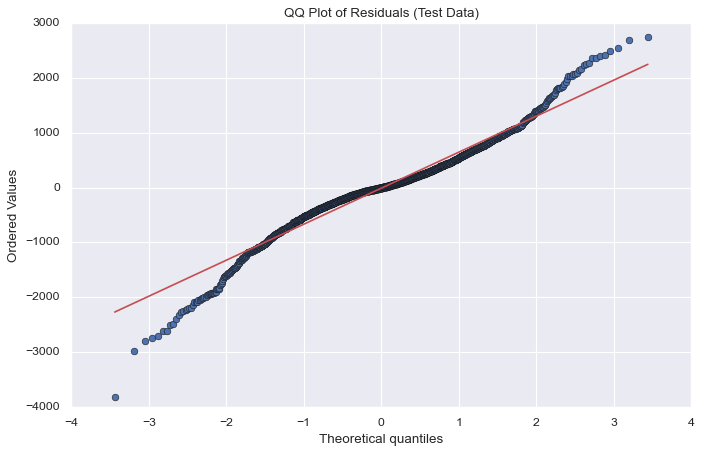

In [147]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()

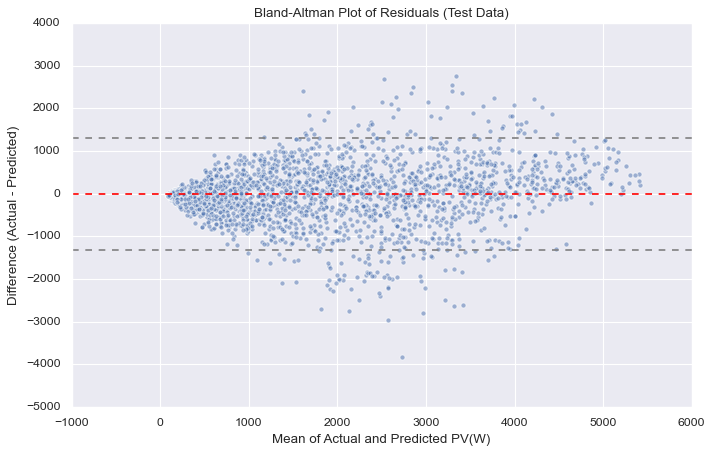

In [148]:
# plot a bland altman plot for residuals
plt.figure(figsize=(10,6))
mean_values = (y_test + y_test_pred) / 2
diff_values = y_test - y_test_pred
plt.scatter(mean_values, diff_values, alpha=0.5)
plt.axhline(np.mean(diff_values), color='red', linestyle='--')
plt.axhline(np.mean(diff_values) + 1.96 * np.std(diff_values), color='gray', linestyle='--')
plt.axhline(np.mean(diff_values) - 1.96 * np.std(diff_values), color='gray', linestyle='--')
plt.title('Bland-Altman Plot of Residuals (Test Data)')
plt.xlabel('Mean of Actual and Predicted PV(W)')
plt.ylabel('Difference (Actual - Predicted)')
plt.show()

Compare a few blah blah

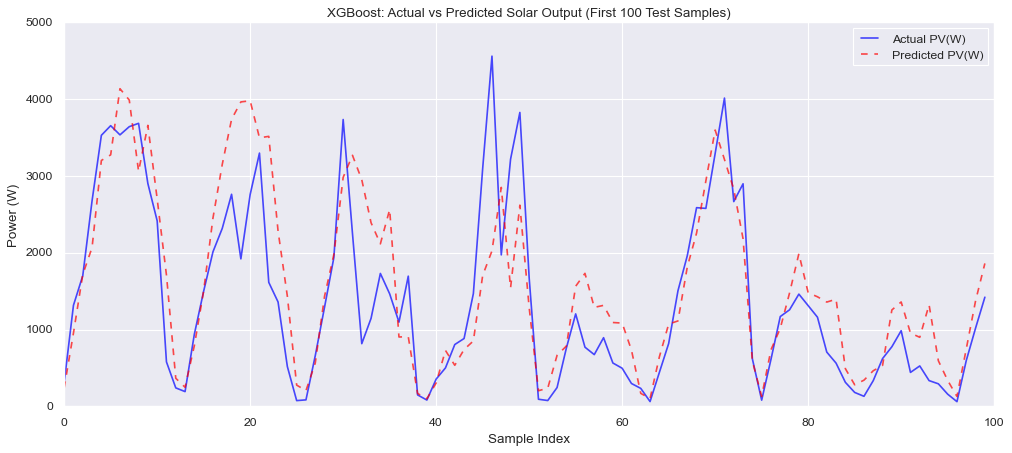

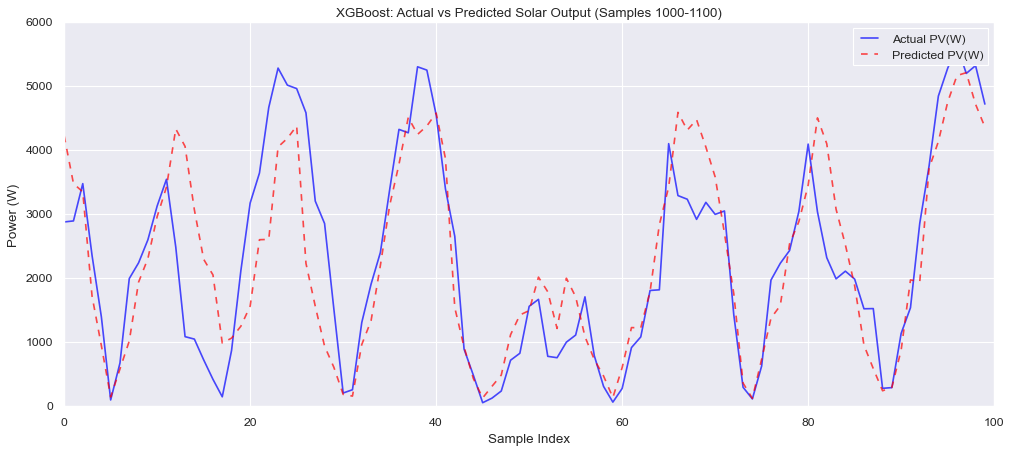

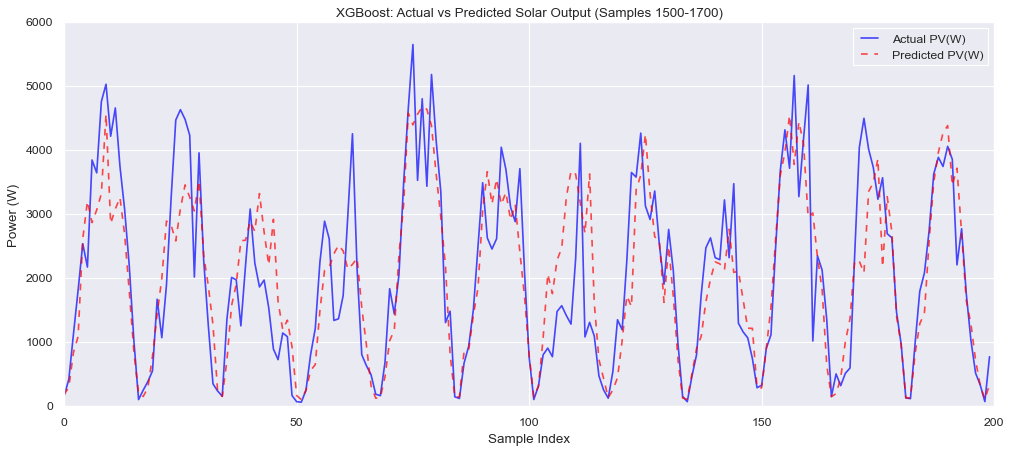

In [149]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_test_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[1000:1100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_test_pred[1000:1100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (Samples 1000-1100)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[1500:1700], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_test_pred[1500:1700], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (Samples 1500-1700)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

__Plot Decision Tree__

This shows a sample of the decision trees used in the random forrest.

[DataCamp - Random Forrest](https://www.datacamp.com/tutorial/random-forests-classifier-python)

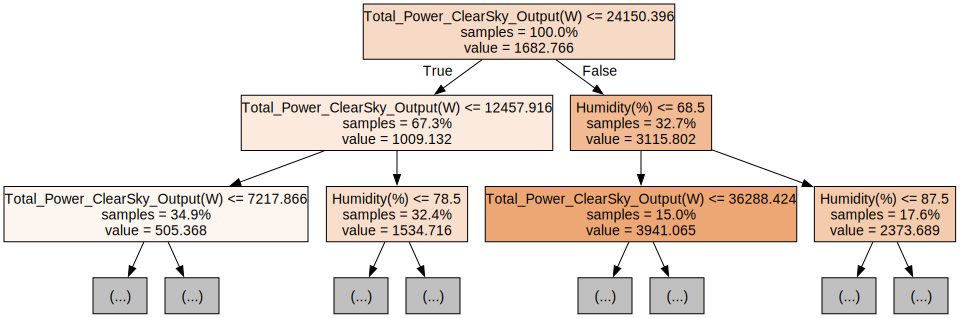

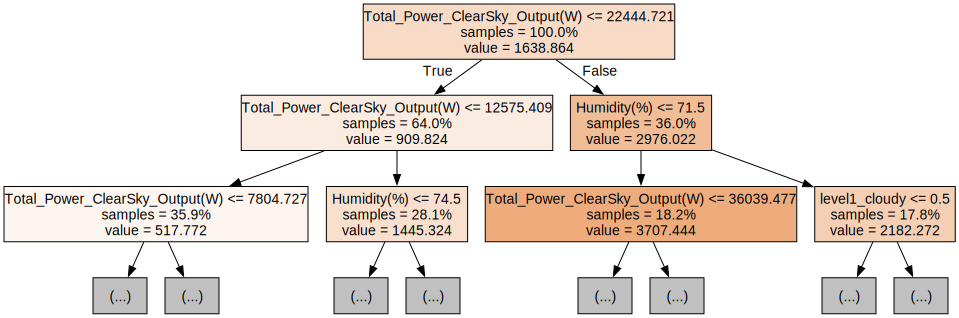

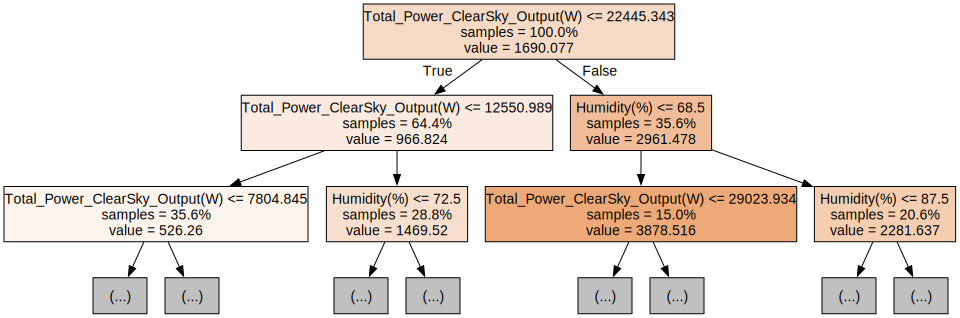

In [150]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)